In [14]:
# 清空内核状态
%reset -f

In [15]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
setup_seed(123456)

In [16]:
#要设置的参数
Ex=0#E也要放小e6倍，这里是0就不放了
Ey=0
Ez=0#托卡马克里面没电场
B0=5#磁轴中心的磁感应强度为5T
q=2.5#安全因子，注意，不是电荷
R0=6.2#托卡马克大半径6.2m
q_over_m = 4.822452834e1  # 电荷与质量之比

#单位问题：跑太大的数，程序吃不消，得归一化。几个大数，q_over_m = 4.8e7，vx0vy0 1e6 5e6，interval 4.1473e-9，要动
#程序中，要让轨迹相对形状不变，又因为B和位置有关，所以轨迹数值也不能变
#a=q/m（E+vB），x=vt+0.5at^2
#让位移x=vt+0.5at^2不变，让interval扩大e6倍，让v缩小e6倍(让v0和x0在同一量级，这样好训练)，让q_over_m缩小e6倍，E也要放小e6倍，这样a放小e12个
def Bx(x,y,z):
    return B0/q*(-q*R0*y+z*x)/(x**2+y**2)
def By(x,y,z):
    return B0/q*(q*R0*x+z*y)/(x**2+y**2)
def Bz(x,y,z):
    return B0/q*(-1+R0/(x**2+y**2)**0.5)
    

target_x0=torch.tensor([7.2])
target_y0=torch.tensor([0.0])
target_z0=torch.tensor([0.0])
target_vx0=torch.tensor([1.0])
target_vy0=torch.tensor([5.0])#这里是通行α粒子数据
target_vz0=torch.tensor([0.0])


interval=4.147267104135095e-4#根据学长给的数据取值,e-3是小圈的1/2π,e-4就是小圈的60分之一，更精确
#总运动时间是n*interval
learning_rate=2e-3

stop_condition = 5e-4#停止训练的loss值要求


#设置初始权重
lamda1=2#lpde权重
lamda2=15#lE权重
lamda3=500#l0权重




In [17]:
n=50#训练中的t共n个时间点,注意画三维图的点不建议超过200个，容易炸内核
n_all=50000#总覆盖时间点数，绘图用
jump=0#单位是interval
n_epoch=100#每几次epoch就计数
n_jump=5#前置训练点
vw=0.972#速度权重

n_test=50#在n_all范围内，等距取多少个test点
new_prefix = "8.2.longsui"  # 新的文件名前缀

In [18]:
#Neural Network
#t作为输入，x,y,z作为输出，中间三个隐藏层
#MLP是最基础的全连接神经网络

class SinActivation(torch.nn.Module):
    def __init__(self):
        super(SinActivation, self).__init__()
        self.a = nn.Parameter(torch.tensor(0.1))  # 将a设置为可学习的参数

    def forward(self, x):
        return torch.sin(self.a *10* x)

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(1,128),#0层
            SinActivation(),#1层
            torch.nn.Linear(128,128),#2层
            SinActivation(),#3
            torch.nn.Linear(128,128),#4
            SinActivation(),#5
            torch.nn.Linear(128,128),#6
            SinActivation(),#7
            torch.nn.Linear(128,3),#8
        )
         # 对每个线性层进行Glorot初始化
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
    def forward(self,x):
        return self.net(x)
    
    
u = MLP()  # 网络名称



In [19]:
# import torch
# #from ceshi_Copy1 import MLP  # 导入你的模型类定义

# # 创建模型实例
# # u = MyModel()

# # 加载模型参数
# u.load_state_dict(torch.load('3.1.1保存.pth'))

# # 设置模型为评估模式（如果只是进行推理）
# # u.eval()

In [20]:


#下面是求导
def gradients(x,t,order=1):
    if order == 1:
        return torch.autograd.grad(x,t,grad_outputs=torch.ones_like(x),#用于计算某个标量相对于一组输入张量的梯度
                                  create_graph = True,
                                  only_inputs=True,)[0]#create_graph： 这是一个布尔值，如果设置为 True，则创建一个用于计算更高阶梯度的计算图。
                                                    #这对于执行高阶梯度的操作是有用的。在训练深度学习模型时，可能需要计算模型参数的二阶梯度。
    else:
        return gradients(gradients(x,t),t,order = order-1)#二阶及以上导

In [21]:


#损失函数
#LOSS
loss = torch.nn.MSELoss()
tensortarget = vw*(target_vx0**2+target_vy0**2+target_vz0**2)**0.5#导心速度

def funcmiu(x,y,z,vx,vy,vz):
    miu=(vx**2+vy**2+vz**2)/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**0.5-(vx*Bx(x,y,z)+vy*By(x,y,z)+vz*Bz(x,y,z))**2/(Bx(x,y,z)**2+By(x,y,z)**2+Bz(x,y,z)**2)**1.5
    return miu


def LOSS1(u):
    
    samples = torch.arange(jump*interval, (10000+1+jump)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    t = samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1).view(-1, 1)#保能量项用的
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0
def LOSS2(u):
    
    samples = torch.arange(10000*interval, (10000+1+10000)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    samples1 = torch.arange(0, 10000*interval, step=int(10000/n_jump)*interval)+torch.rand(n_jump+1) * interval*int(10000/n_jump)*1
    connected_samples = torch.cat((samples, samples1), dim=0)
    t = connected_samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1+n_jump+1).view(-1, 1)#保能量项用的
    
    
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0
def LOSS3(u):
    
    samples = torch.arange(20000*interval, (10000+1+20000)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    samples1 = torch.arange(0, 20000*interval, step=int(10000/n_jump)*interval)+torch.rand(n_jump+1+n_jump) * interval*int(10000/n_jump)*1
    connected_samples = torch.cat((samples, samples1), dim=0)
    t = connected_samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1+n_jump+1+n_jump).view(-1, 1)#保能量项用的
    
    
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0
def LOSS4(u):
    
    samples = torch.arange(30000*interval, (10000+1+30000)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    samples1 = torch.arange(0, 30000*interval, step=int(10000/n_jump)*interval)+torch.rand(n_jump+n_jump+n_jump) * interval*int(10000/n_jump)*1
    connected_samples = torch.cat((samples, samples1), dim=0)
    t = connected_samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1+n_jump+n_jump+n_jump).view(-1, 1)#保能量项用的
    
    
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0
def LOSS5(u):
    
    samples = torch.arange(40000*interval, (10000+1+40000)*interval, step=int(10000/n)*interval)+torch.rand(n+1) * interval*int(10000/n)*1   #random jitter to samples 10%#实际上n+1个点
    samples1 = torch.arange(0, 40000*interval, step=int(10000/n_jump)*interval)+torch.rand(n_jump+1+n_jump+n_jump+n_jump) * interval*int(10000/n_jump)*1
    connected_samples = torch.cat((samples, samples1), dim=0)
    t = connected_samples.view(-1, 1).requires_grad_(True)
    target_initial = tensortarget.repeat(n+1+n_jump+1+n_jump+n_jump+n_jump).view(-1, 1)#保能量项用的
    
    
    x = u(t)[:, 0].view(-1, 1)
    y = u(t)[:, 1].view(-1, 1)
    z = u(t)[:, 2].view(-1, 1)
    vx = gradients(x, t, 1)
    vy = gradients(y, t, 1)
    vz = gradients(z, t, 1)

    lpde1 = loss(gradients(vx, t, 1), q_over_m*(Ex + vy * Bz(x,y,z) - vz * By(x,y,z)))
    lpde2 = loss(gradients(vy, t, 1), q_over_m*(Ey + vz * Bx(x,y,z) - vx * Bz(x,y,z)))
    lpde3 = loss(gradients(vz, t, 1), q_over_m*(Ez + vx * By(x,y,z) - vy * Bx(x,y,z)))

    lE = loss((vx**2+vy**2+vz**2)**0.5,target_initial)
    miu=funcmiu(x,y,z,vx,vy,vz)
    lpde = lpde1 + lpde2 + lpde3 

    t0=torch.tensor([0.0]).requires_grad_(True)
    l00=(u(t0)[0] - target_x0)**2
    l01=(u(t0)[1] - target_y0)**2
    l02=(u(t0)[2] - target_z0)**2
    l03=(gradients(u(t0)[0],t0,1) - target_vx0)**2
    l04=(gradients(u(t0)[1],t0,1) - target_vy0)**2
    l05=(gradients(u(t0)[2],t0,1) - target_vz0)**2
    l0=l00+l01+l02+l03+l04+l05

    return lpde,lE,l0


In [22]:
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)
def funcweight(lpde):
    lpde.backward(retain_graph=True)#初态只对第0层的weight的梯度才全是0，其他情况都有梯度
    # 获取网络的参数列表
    gradientlw0 = u.net[0].weight.grad.clone()
    gradientlb0 = u.net[0].bias.grad.clone()
    gradientlw2 = u.net[2].weight.grad.clone()
    gradientlb2 = u.net[2].bias.grad.clone()
    gradientlw4 = u.net[4].weight.grad.clone()
    gradientlb4 = u.net[4].bias.grad.clone()
    gradientlw6 = u.net[6].weight.grad.clone()
    gradientlb6 = u.net[6].bias.grad.clone()
    gradientlw8 = u.net[8].weight.grad.clone()
    gradientlb8 = u.net[8].bias.grad.clone()
    opt.zero_grad()
    tensors_l = [gradientlw0,gradientlb0,gradientlw2,gradientlb2,gradientlw4,gradientlb4,gradientlw6,gradientlb6,
                gradientlw8,gradientlb8]
    squared_sums = [torch.sum(tensor ** 2) for tensor in tensors_l]
    # 将所有平方和相加
    total_squared_sum = sum(squared_sums)
    l2_norm_gradient_l=(total_squared_sum.item())**0.5
    return l2_norm_gradient_l

In [23]:
# 加载文本文件
xdata = np.loadtxt('通行x_real.txt')
# 从第四个数据开始，每隔10个数据读取一个，共读取50个数据
xselected_data = xdata[jump::500][:(100+1)]
# 将所选数据转换为PyTorch张量
x_real = torch.tensor(xselected_data, dtype=torch.float32).view(-1,1)

ydata = np.loadtxt('通行y_real.txt')
yselected_data = ydata[jump::500][:(100+1)]
y_real = torch.tensor(yselected_data, dtype=torch.float32).view(-1,1)

zdata = np.loadtxt('通行z_real.txt')
zselected_data = zdata[jump::500][:(100+1)]
z_real = torch.tensor(zselected_data, dtype=torch.float32).view(-1,1)



#全500点，用于后续绘图
x_plt=xdata[jump:(n_all+1+jump):20]
y_plt=ydata[jump:(n_all+1+jump):20]
z_plt=zdata[jump:(n_all+1+jump):20]
x_real_plt=torch.tensor(x_plt, dtype=torch.float32).view(-1,1)#真实值的0~500点，
y_real_plt=torch.tensor(y_plt, dtype=torch.float32).view(-1,1)
z_real_plt=torch.tensor(z_plt, dtype=torch.float32).view(-1,1)

xdata=[]
ydata=[]
zdata=[]#清空这二百四十万个数据

#x_real：用于训练过程神经网络输出值与真实值对比，3，13,23…493共50个时刻点，对应t_test
#x_real_plt：用于绘制真实图，0~500全点


In [24]:
#训练过程中记录的量
loss_list=[]#总损失，带权重
lpde_list=[]#方程项损失
l0_list=[]#初态损失
lE_list=[]#能量项损失loss，也是与真实能量做对比diff
lamda1_list=[]#方程项权重，把保能量保磁矩也放在这一项
lamda2_list=[]#能量项权重
lamda3_list=[]#初态权重
l_withoutweight_list=[]#总损失，不带权重
time_list=[]#训练时间记录
loss_test_list=[]#部分时刻点，输出位置与真实位置误差向量的模平方，即位置与真实值的误差
lossmean_test_list=[]#部分时刻点，输出位置与真实位置误差的算术平均值，(sigma（xn+yn+zn）-sigma(xc+yc+zc))/n ,证明轨迹可以视为导心
miu_train_list=[]

In [25]:
def plot_trajectory_during_loop():
    #计算神经网络的轨迹
    output_history= []#想要缩短周期，就调大Bz
    for i in range(jump,(n_all+1+jump),20):
            # 将当前状态输入神经网络得到下一时刻的状态
            next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

            # 记录输出值
            output_history.append(next_state)

    import numpy as np
    x_coordinates = np.array([x[0].item() for x in output_history])
    y_coordinates = np.array([x[1].item() for x in output_history])
    z_coordinates = np.array([x[2].item() for x in output_history])
    #绘制轨迹，2维
    plt.plot(x_coordinates,y_coordinates, linestyle='--',label='PINN')
    plt.plot(x_real_plt, y_real_plt,label='VPA')


    plt.legend()
    plt.xlabel('X')
    plt.ylabel('Y')
#     plt.title('PINN neural network VS classic calculation')
    plt.show()

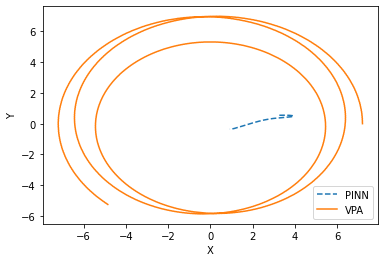

Epoch [1/24000], Loss: 2.904e+05,   LOSS_function: 1.28e+05,   LOSS_E:22.95,    LOSS_initial: 68.01,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 1.1517589092254639
loss_compared with real:54.716,   miu_train:0.01294,    lossmean:-0.2927
Epoch [100/24000], Loss: 775.5,   LOSS_function: 28.01,   LOSS_E:13.61,    LOSS_initial: 1.031,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 7.960232973098755
loss_compared with real:44.826,   miu_train:0.0002032,    lossmean:2.183
Epoch [200/24000], Loss: 509.9,   LOSS_function: 17.08,   LOSS_E:12.07,    LOSS_initial: 0.5893,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 14.66388726234436
loss_compared with real:37.434,   miu_train:0.0001587,    lossmean:2.05
Epoch [300/24000], Loss: 613.3,   LOSS_function: 99.46,   LOSS_E:10.12,    LOSS_initial: 0.5252,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 22.088027477264404
loss_compared with real:31.567,  

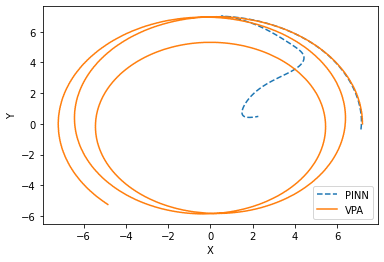

Epoch [600/24000], Loss: 401,   LOSS_function: 26.66,   LOSS_E:6.308,    LOSS_initial: 0.5061,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 61.69082736968994
loss_compared with real:22.503,   miu_train:0.0006965,    lossmean:1.761
Epoch [700/24000], Loss: 385,   LOSS_function: 34.19,   LOSS_E:5.856,    LOSS_initial: 0.4576,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 73.38841462135315
loss_compared with real:23.795,   miu_train:0.0008669,    lossmean:1.796
Epoch [800/24000], Loss: 380.3,   LOSS_function: 42.68,   LOSS_E:4.816,    LOSS_initial: 0.4455,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 81.80598211288452
loss_compared with real:18.463,   miu_train:0.0008303,    lossmean:1.617
Epoch [900/24000], Loss: 340.5,   LOSS_function: 33.98,   LOSS_E:4.2,    LOSS_initial: 0.4191,
lamda1:2,    lamda2:15,    lamda3:500,      learn rate:0.002,    time: 89.7017228603363
loss_compared with real:18.038,   miu_train:

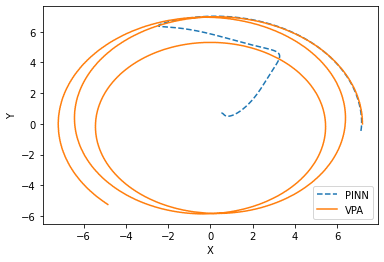

Epoch [1100/24000], Loss: 1404,   LOSS_function: 605,   LOSS_E:1.395,    LOSS_initial: 0.7414,
lamda1:1.504,    lamda2:136.6,    lamda3:410.4,      learn rate:0.00188,    time: 105.59883260726929
loss_compared with real:10.227,   miu_train:0.00483,    lossmean:1.376
Epoch [1200/24000], Loss: 996.4,   LOSS_function: 156.6,   LOSS_E:4.049,    LOSS_initial: 0.5068,
lamda1:1.504,    lamda2:136.6,    lamda3:410.4,      learn rate:0.00188,    time: 113.05557799339294
loss_compared with real:20.982,   miu_train:0.001393,    lossmean:1.802
Epoch [1300/24000], Loss: 294.6,   LOSS_function: 29.09,   LOSS_E:0.5455,    LOSS_initial: 0.4299,
lamda1:1.504,    lamda2:136.6,    lamda3:410.4,      learn rate:0.00188,    time: 121.19012522697449
loss_compared with real:4.6418,   miu_train:0.002289,    lossmean:0.9016
Epoch [1400/24000], Loss: 218.9,   LOSS_function: 41.47,   LOSS_E:0.2044,    LOSS_initial: 0.3134,
lamda1:1.504,    lamda2:136.6,    lamda3:410.4,      learn rate:0.00188,    time: 128.8849

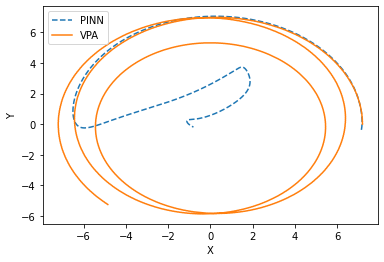

Epoch [1600/24000], Loss: 339.9,   LOSS_function: 101.7,   LOSS_E:0.07085,    LOSS_initial: 0.432,
lamda1:1.504,    lamda2:136.6,    lamda3:410.4,      learn rate:0.00188,    time: 146.08173990249634
loss_compared with real:0.54894,   miu_train:0.001469,    lossmean:0.3212
Epoch [1700/24000], Loss: 255.5,   LOSS_function: 51.72,   LOSS_E:0.09932,    LOSS_initial: 0.4,
lamda1:1.504,    lamda2:136.6,    lamda3:410.4,      learn rate:0.00188,    time: 154.23832368850708
loss_compared with real:0.90993,   miu_train:0.001509,    lossmean:0.3711
Epoch [1800/24000], Loss: 198.2,   LOSS_function: 52.04,   LOSS_E:0.04637,    LOSS_initial: 0.2768,
lamda1:1.504,    lamda2:136.6,    lamda3:410.4,      learn rate:0.00188,    time: 161.81719398498535
loss_compared with real:0.45519,   miu_train:0.002206,    lossmean:0.2843
Epoch [1900/24000], Loss: 272,   LOSS_function: 104.5,   LOSS_E:0.04617,    LOSS_initial: 0.2644,
lamda1:1.504,    lamda2:136.6,    lamda3:410.4,      learn rate:0.00188,    time:

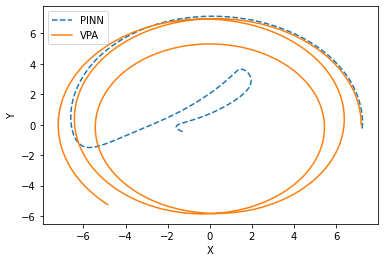

Epoch [2100/24000], Loss: 710,   LOSS_function: 435.9,   LOSS_E:0.004013,    LOSS_initial: 0.1155,
lamda1:1.252,    lamda2:8852,    lamda3:1115,      learn rate:0.001767,    time: 186.71150302886963
loss_compared with real:0.10367,   miu_train:0.002122,    lossmean:0.1554
Epoch [2200/24000], Loss: 724.8,   LOSS_function: 233.8,   LOSS_E:0.006674,    LOSS_initial: 0.3347,
lamda1:1.252,    lamda2:8852,    lamda3:1115,      learn rate:0.001767,    time: 195.03211450576782
loss_compared with real:0.24079,   miu_train:0.002837,    lossmean:0.2096
Epoch [2300/24000], Loss: 777.2,   LOSS_function: 489.5,   LOSS_E:0.00634,    LOSS_initial: 0.09706,
lamda1:1.252,    lamda2:8852,    lamda3:1115,      learn rate:0.001767,    time: 203.51578450202942
loss_compared with real:0.050531,   miu_train:0.001597,    lossmean:0.1094
Epoch [2400/24000], Loss: 598.8,   LOSS_function: 272.4,   LOSS_E:0.00285,    LOSS_initial: 0.2086,
lamda1:1.252,    lamda2:8852,    lamda3:1115,      learn rate:0.001767,    t

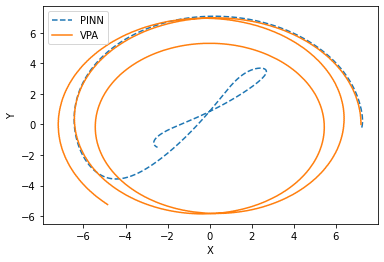

Epoch [2600/24000], Loss: 603.1,   LOSS_function: 269.2,   LOSS_E:0.003003,    LOSS_initial: 0.2148,
lamda1:1.252,    lamda2:8852,    lamda3:1115,      learn rate:0.001767,    time: 231.41424918174744
loss_compared with real:0.18595,   miu_train:0.002678,    lossmean:0.179
Epoch [2700/24000], Loss: 363.7,   LOSS_function: 113.3,   LOSS_E:0.003226,    LOSS_initial: 0.1734,
lamda1:1.252,    lamda2:8852,    lamda3:1115,      learn rate:0.001767,    time: 239.60721445083618
loss_compared with real:0.17644,   miu_train:0.006102,    lossmean:0.154
Epoch [2800/24000], Loss: 664.6,   LOSS_function: 402.5,   LOSS_E:0.005879,    LOSS_initial: 0.09743,
lamda1:1.252,    lamda2:8852,    lamda3:1115,      learn rate:0.001767,    time: 247.46763253211975
loss_compared with real:0.048216,   miu_train:0.002297,    lossmean:0.1124
Epoch [2900/24000], Loss: 259.7,   LOSS_function: 99.17,   LOSS_E:0.001372,    LOSS_initial: 0.1107,
lamda1:1.252,    lamda2:8852,    lamda3:1115,      learn rate:0.001767,   

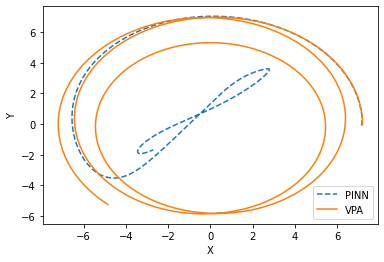

Epoch [3100/24000], Loss: 401.8,   LOSS_function: 152.3,   LOSS_E:0.0003532,    LOSS_initial: 0.1438,
lamda1:1.126,    lamda2:1.697e+04,    lamda3:1560,      learn rate:0.001661,    time: 272.4842839241028
loss_compared with real:0.14277,   miu_train:0.006147,    lossmean:0.1601
Epoch [3200/24000], Loss: 765.7,   LOSS_function: 179.8,   LOSS_E:0.0008063,    LOSS_initial: 0.3522,
lamda1:1.126,    lamda2:1.697e+04,    lamda3:1560,      learn rate:0.001661,    time: 279.87615633010864
loss_compared with real:0.16449,   miu_train:0.005117,    lossmean:0.166
Epoch [3300/24000], Loss: 323.2,   LOSS_function: 73.78,   LOSS_E:0.002106,    LOSS_initial: 0.131,
lamda1:1.126,    lamda2:1.697e+04,    lamda3:1560,      learn rate:0.001661,    time: 287.7073075771332
loss_compared with real:0.11501,   miu_train:0.009038,    lossmean:0.127
Epoch [3400/24000], Loss: 943.8,   LOSS_function: 248.1,   LOSS_E:0.003215,    LOSS_initial: 0.3909,
lamda1:1.126,    lamda2:1.697e+04,    lamda3:1560,      learn 

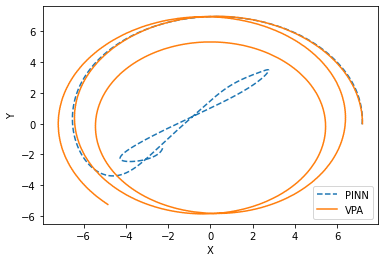

Epoch [3600/24000], Loss: 309.6,   LOSS_function: 88.97,   LOSS_E:0.006038,    LOSS_initial: 0.06851,
lamda1:1.126,    lamda2:1.697e+04,    lamda3:1560,      learn rate:0.001661,    time: 312.32205867767334
loss_compared with real:0.071072,   miu_train:0.009028,    lossmean:0.1013
Epoch [3700/24000], Loss: 417.7,   LOSS_function: 129.5,   LOSS_E:0.004537,    LOSS_initial: 0.1249,
lamda1:1.126,    lamda2:1.697e+04,    lamda3:1560,      learn rate:0.001661,    time: 320.0929834842682
loss_compared with real:0.042337,   miu_train:0.008523,    lossmean:0.09867
Epoch [3800/24000], Loss: 419.2,   LOSS_function: 45.55,   LOSS_E:0.001626,    LOSS_initial: 0.2181,
lamda1:1.126,    lamda2:1.697e+04,    lamda3:1560,      learn rate:0.001661,    time: 328.0956029891968
loss_compared with real:0.10254,   miu_train:0.005234,    lossmean:0.1579
Epoch [3900/24000], Loss: 377.4,   LOSS_function: 88.65,   LOSS_E:0.003141,    LOSS_initial: 0.1438,
lamda1:1.126,    lamda2:1.697e+04,    lamda3:1560,      l

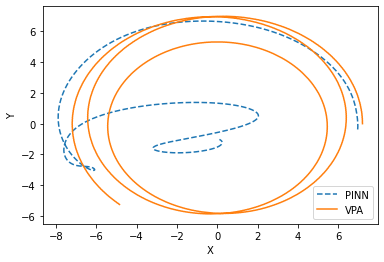

Epoch [4100/24000], Loss: 1.467e+04,   LOSS_function: 3657,   LOSS_E:0.2946,    LOSS_initial: 0.2837,
lamda1:1.063,    lamda2:3.503e+04,    lamda3:1628,      learn rate:0.001561,    time: 353.16788721084595
loss_compared with real:127.85,   miu_train:0.1394,    lossmean:4.517
Epoch [4200/24000], Loss: 8122,   LOSS_function: 4647,   LOSS_E:0.08297,    LOSS_initial: 0.1688,
lamda1:1.063,    lamda2:3.503e+04,    lamda3:1628,      learn rate:0.001561,    time: 361.2478063106537
loss_compared with real:116.04,   miu_train:0.1434,    lossmean:3.987
Epoch [4300/24000], Loss: 3800,   LOSS_function: 1957,   LOSS_E:0.02942,    LOSS_initial: 0.4231,
lamda1:1.063,    lamda2:3.503e+04,    lamda3:1628,      learn rate:0.001561,    time: 369.19064235687256
loss_compared with real:35.362,   miu_train:0.1381,    lossmean:-0.4481
Epoch [4400/24000], Loss: 583.1,   LOSS_function: 495.7,   LOSS_E:0.0009219,    LOSS_initial: 0.01457,
lamda1:1.063,    lamda2:3.503e+04,    lamda3:1628,      learn rate:0.0015

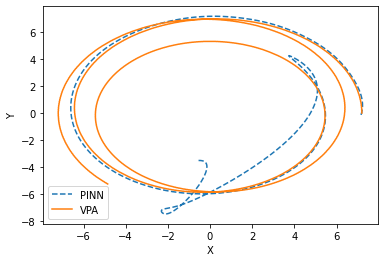

Epoch [4600/24000], Loss: 585,   LOSS_function: 450,   LOSS_E:0.001771,    LOSS_initial: 0.02724,
lamda1:1.063,    lamda2:3.503e+04,    lamda3:1628,      learn rate:0.001561,    time: 393.828085899353
loss_compared with real:0.37422,   miu_train:0.006374,    lossmean:-0.1261
Epoch [4700/24000], Loss: 56.26,   LOSS_function: 22.72,   LOSS_E:0.0002894,    LOSS_initial: 0.01348,
lamda1:1.063,    lamda2:3.503e+04,    lamda3:1628,      learn rate:0.001561,    time: 402.59224224090576
loss_compared with real:0.35637,   miu_train:0.005333,    lossmean:-0.1001
Epoch [4800/24000], Loss: 49.43,   LOSS_function: 25.05,   LOSS_E:0.0005349,    LOSS_initial: 0.00249,
lamda1:1.063,    lamda2:3.503e+04,    lamda3:1628,      learn rate:0.001561,    time: 411.4972450733185
loss_compared with real:0.2503,   miu_train:0.006852,    lossmean:-0.1026
Epoch [4900/24000], Loss: 289.1,   LOSS_function: 255.5,   LOSS_E:0.0003468,    LOSS_initial: 0.00318,
lamda1:1.063,    lamda2:3.503e+04,    lamda3:1628,      l

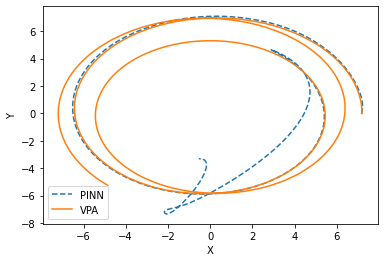

Epoch [5100/24000], Loss: 729.8,   LOSS_function: 674.7,   LOSS_E:0.0003495,    LOSS_initial: 0.003313,
lamda1:1.032,    lamda2:6.417e+04,    lamda3:3380,      learn rate:0.001468,    time: 436.51155376434326
loss_compared with real:0.15138,   miu_train:0.005763,    lossmean:-0.06229
Epoch [5200/24000], Loss: 97.6,   LOSS_function: 35.59,   LOSS_E:0.0004326,    LOSS_initial: 0.009797,
lamda1:1.032,    lamda2:6.417e+04,    lamda3:3380,      learn rate:0.001468,    time: 444.7626302242279
loss_compared with real:0.20024,   miu_train:0.00643,    lossmean:-0.1087
Epoch [5300/24000], Loss: 107.5,   LOSS_function: 59.06,   LOSS_E:0.0006202,    LOSS_initial: 0.002004,
lamda1:1.032,    lamda2:6.417e+04,    lamda3:3380,      learn rate:0.001468,    time: 452.31699442863464
loss_compared with real:0.19971,   miu_train:0.00563,    lossmean:-0.09772
Epoch [5400/24000], Loss: 1130,   LOSS_function: 804.7,   LOSS_E:0.003941,    LOSS_initial: 0.01383,
lamda1:1.032,    lamda2:6.417e+04,    lamda3:3380

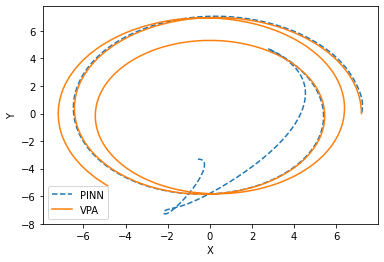

Epoch [5600/24000], Loss: 517.6,   LOSS_function: 134.1,   LOSS_E:0.005318,    LOSS_initial: 0.01125,
lamda1:1.032,    lamda2:6.417e+04,    lamda3:3380,      learn rate:0.001468,    time: 480.03353452682495
loss_compared with real:0.67115,   miu_train:0.006688,    lossmean:-0.2597
Epoch [5700/24000], Loss: 61.43,   LOSS_function: 25,   LOSS_E:0.000321,    LOSS_initial: 0.004447,
lamda1:1.032,    lamda2:6.417e+04,    lamda3:3380,      learn rate:0.001468,    time: 488.2280831336975
loss_compared with real:0.27635,   miu_train:0.006667,    lossmean:-0.1248
Epoch [5800/24000], Loss: 92.35,   LOSS_function: 32.35,   LOSS_E:0.0003558,    LOSS_initial: 0.01069,
lamda1:1.032,    lamda2:6.417e+04,    lamda3:3380,      learn rate:0.001468,    time: 496.35675835609436
loss_compared with real:0.13419,   miu_train:0.005634,    lossmean:-0.07131
Epoch [5900/24000], Loss: 913.2,   LOSS_function: 753.2,   LOSS_E:0.001994,    LOSS_initial: 0.002402,
lamda1:1.032,    lamda2:6.417e+04,    lamda3:3380,  

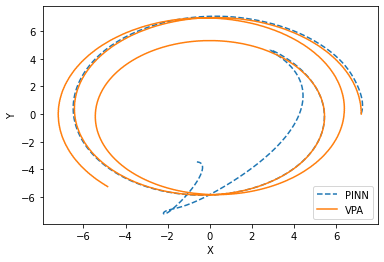

Epoch [6100/24000], Loss: 57.02,   LOSS_function: 20.83,   LOSS_E:0.0002656,    LOSS_initial: 0.004832,
lamda1:1.016,    lamda2:6.381e+04,    lamda3:3913,      learn rate:0.00138,    time: 522.6425535678864
loss_compared with real:0.069291,   miu_train:0.007206,    lossmean:-0.03818
Epoch [6200/24000], Loss: 158.4,   LOSS_function: 24.32,   LOSS_E:0.0008431,    LOSS_initial: 0.02042,
lamda1:1.016,    lamda2:6.381e+04,    lamda3:3913,      learn rate:0.00138,    time: 531.4212865829468
loss_compared with real:0.14979,   miu_train:0.006412,    lossmean:-0.07037
Epoch [6300/24000], Loss: 86.66,   LOSS_function: 44.29,   LOSS_E:0.0002595,    LOSS_initial: 0.006416,
lamda1:1.016,    lamda2:6.381e+04,    lamda3:3913,      learn rate:0.00138,    time: 544.3753898143768
loss_compared with real:0.3448,   miu_train:0.007321,    lossmean:-0.1323
Epoch [6400/24000], Loss: 51.07,   LOSS_function: 10.62,   LOSS_E:0.0002907,    LOSS_initial: 0.005554,
lamda1:1.016,    lamda2:6.381e+04,    lamda3:3913

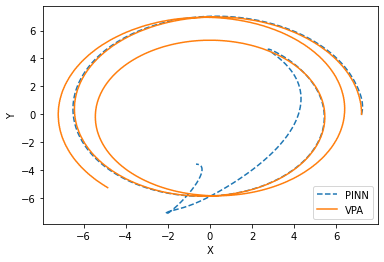

Epoch [6600/24000], Loss: 61.22,   LOSS_function: 24.23,   LOSS_E:0.0004394,    LOSS_initial: 0.002188,
lamda1:1.016,    lamda2:6.381e+04,    lamda3:3913,      learn rate:0.00138,    time: 578.8920829296112
loss_compared with real:0.12703,   miu_train:0.006947,    lossmean:-0.04059
Epoch [6700/24000], Loss: 127.7,   LOSS_function: 52.78,   LOSS_E:0.0009768,    LOSS_initial: 0.003009,
lamda1:1.016,    lamda2:6.381e+04,    lamda3:3913,      learn rate:0.00138,    time: 590.1053576469421
loss_compared with real:0.099745,   miu_train:0.006445,    lossmean:-0.1175
Epoch [6800/24000], Loss: 161.1,   LOSS_function: 105.6,   LOSS_E:0.0005801,    LOSS_initial: 0.004282,
lamda1:1.016,    lamda2:6.381e+04,    lamda3:3913,      learn rate:0.00138,    time: 597.5226957798004
loss_compared with real:0.14384,   miu_train:0.006446,    lossmean:-0.05243
Epoch [6900/24000], Loss: 204.7,   LOSS_function: 70.71,   LOSS_E:0.0004911,    LOSS_initial: 0.02595,
lamda1:1.016,    lamda2:6.381e+04,    lamda3:391

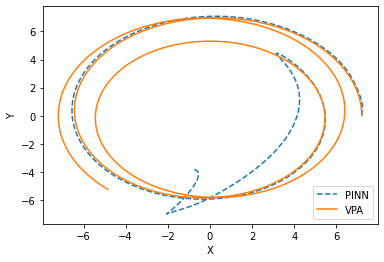

Epoch [7100/24000], Loss: 52.71,   LOSS_function: 5.278,   LOSS_E:0.0004481,    LOSS_initial: 0.00612,
lamda1:1.008,    lamda2:4.332e+04,    lamda3:4571,      learn rate:0.001297,    time: 622.7763271331787
loss_compared with real:0.1157,   miu_train:0.005869,    lossmean:-0.04731
Epoch [7200/24000], Loss: 54.68,   LOSS_function: 36.61,   LOSS_E:7.251e-05,    LOSS_initial: 0.003202,
lamda1:1.008,    lamda2:4.332e+04,    lamda3:4571,      learn rate:0.001297,    time: 630.8142147064209
loss_compared with real:0.074629,   miu_train:0.00695,    lossmean:-0.05517
Epoch [7300/24000], Loss: 63.55,   LOSS_function: 25.7,   LOSS_E:0.0003345,    LOSS_initial: 0.005063,
lamda1:1.008,    lamda2:4.332e+04,    lamda3:4571,      learn rate:0.001297,    time: 638.7874956130981
loss_compared with real:0.15498,   miu_train:0.005462,    lossmean:-0.06027
Epoch [7400/24000], Loss: 7.835,   LOSS_function: 1.61,   LOSS_E:4.359e-05,    LOSS_initial: 0.0009459,
lamda1:1.008,    lamda2:4.332e+04,    lamda3:45

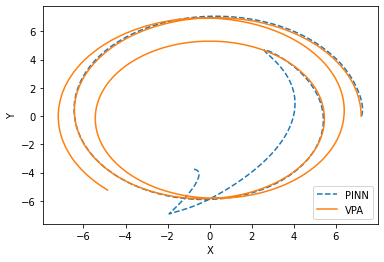

Epoch [7600/24000], Loss: 300.3,   LOSS_function: 32.07,   LOSS_E:0.000206,    LOSS_initial: 0.05667,
lamda1:1.008,    lamda2:4.332e+04,    lamda3:4571,      learn rate:0.001297,    time: 664.2571728229523
loss_compared with real:0.17288,   miu_train:0.006028,    lossmean:-0.07843
Epoch [7700/24000], Loss: 171.9,   LOSS_function: 37.06,   LOSS_E:0.0008167,    LOSS_initial: 0.0217,
lamda1:1.008,    lamda2:4.332e+04,    lamda3:4571,      learn rate:0.001297,    time: 672.48224401474
loss_compared with real:0.12235,   miu_train:0.006035,    lossmean:-0.06704
Epoch [7800/24000], Loss: 777.8,   LOSS_function: 662.4,   LOSS_E:0.001698,    LOSS_initial: 0.00797,
lamda1:1.008,    lamda2:4.332e+04,    lamda3:4571,      learn rate:0.001297,    time: 681.1808748245239
loss_compared with real:0.14688,   miu_train:0.006178,    lossmean:-0.1134
Epoch [7900/24000], Loss: 95.59,   LOSS_function: 38.28,   LOSS_E:0.0004382,    LOSS_initial: 0.008318,
lamda1:1.008,    lamda2:4.332e+04,    lamda3:4571,   

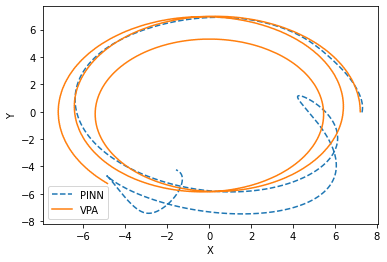

Epoch [8100/24000], Loss: 9897,   LOSS_function: 8410,   LOSS_E:0.01485,    LOSS_initial: 0.01994,
lamda1:1.004,    lamda2:7.697e+04,    lamda3:1.553e+04,      learn rate:0.001219,    time: 707.3490569591522
loss_compared with real:191.73,   miu_train:0.5016,    lossmean:-7.592
Epoch [8200/24000], Loss: 4547,   LOSS_function: 3959,   LOSS_E:0.006701,    LOSS_initial: 0.003579,
lamda1:1.004,    lamda2:7.697e+04,    lamda3:1.553e+04,      learn rate:0.001219,    time: 715.7988660335541
loss_compared with real:126.87,   miu_train:0.178,    lossmean:-6.239
Epoch [8300/24000], Loss: 2755,   LOSS_function: 1876,   LOSS_E:0.006288,    LOSS_initial: 0.02493,
lamda1:1.004,    lamda2:7.697e+04,    lamda3:1.553e+04,      learn rate:0.001219,    time: 724.0031576156616
loss_compared with real:73.379,   miu_train:0.06474,    lossmean:-2.166
Epoch [8400/24000], Loss: 1079,   LOSS_function: 850,   LOSS_E:0.002198,    LOSS_initial: 0.003617,
lamda1:1.004,    lamda2:7.697e+04,    lamda3:1.553e+04,     

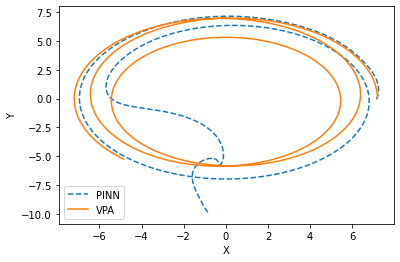

Epoch [8600/24000], Loss: 2019,   LOSS_function: 1329,   LOSS_E:0.003321,    LOSS_initial: 0.02758,
lamda1:1.004,    lamda2:7.697e+04,    lamda3:1.553e+04,      learn rate:0.001219,    time: 751.7916278839111
loss_compared with real:6.8824,   miu_train:0.009802,    lossmean:1.089
Epoch [8700/24000], Loss: 257.3,   LOSS_function: 129.1,   LOSS_E:0.0003467,    LOSS_initial: 0.006507,
lamda1:1.004,    lamda2:7.697e+04,    lamda3:1.553e+04,      learn rate:0.001219,    time: 760.4163806438446
loss_compared with real:4.5979,   miu_train:0.008614,    lossmean:0.6725
Epoch [8800/24000], Loss: 1266,   LOSS_function: 1096,   LOSS_E:0.0006747,    LOSS_initial: 0.007343,
lamda1:1.004,    lamda2:7.697e+04,    lamda3:1.553e+04,      learn rate:0.001219,    time: 769.1213202476501
loss_compared with real:3.1169,   miu_train:0.006097,    lossmean:0.4754
Epoch [8900/24000], Loss: 360.2,   LOSS_function: 259.1,   LOSS_E:0.0005682,    LOSS_initial: 0.003626,
lamda1:1.004,    lamda2:7.697e+04,    lamda3:

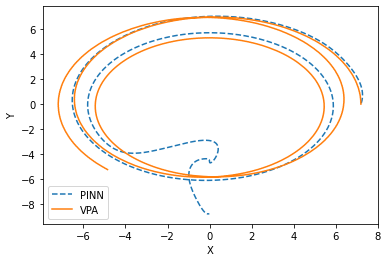

Epoch [9100/24000], Loss: 66.17,   LOSS_function: 36.23,   LOSS_E:0.0003776,    LOSS_initial: 0.001369,
lamda1:1.002,    lamda2:4.745e+04,    lamda3:8717,      learn rate:0.001146,    time: 796.1798551082611
loss_compared with real:1.2816,   miu_train:0.005396,    lossmean:0.2956
Epoch [9200/24000], Loss: 55.49,   LOSS_function: 34.46,   LOSS_E:0.000296,    LOSS_initial: 0.0007924,
lamda1:1.002,    lamda2:4.745e+04,    lamda3:8717,      learn rate:0.001146,    time: 805.3626244068146
loss_compared with real:0.89798,   miu_train:0.005022,    lossmean:0.3465
Epoch [9300/24000], Loss: 59.45,   LOSS_function: 27.67,   LOSS_E:0.0001611,    LOSS_initial: 0.00276,
lamda1:1.002,    lamda2:4.745e+04,    lamda3:8717,      learn rate:0.001146,    time: 814.4926731586456
loss_compared with real:0.85217,   miu_train:0.00538,    lossmean:0.3999
Epoch [9400/24000], Loss: 91.11,   LOSS_function: 60.03,   LOSS_E:0.0002153,    LOSS_initial: 0.002377,
lamda1:1.002,    lamda2:4.745e+04,    lamda3:8717,   

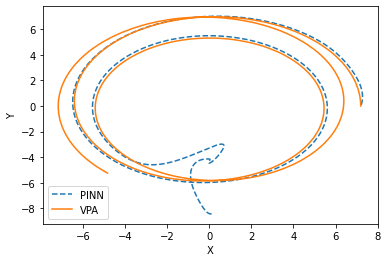

Epoch [9600/24000], Loss: 134.8,   LOSS_function: 101.5,   LOSS_E:0.0002516,    LOSS_initial: 0.002424,
lamda1:1.002,    lamda2:4.745e+04,    lamda3:8717,      learn rate:0.001146,    time: 842.686304807663
loss_compared with real:0.45005,   miu_train:0.004735,    lossmean:0.2692
Epoch [9700/24000], Loss: 98.6,   LOSS_function: 42.49,   LOSS_E:0.0001111,    LOSS_initial: 0.00582,
lamda1:1.002,    lamda2:4.745e+04,    lamda3:8717,      learn rate:0.001146,    time: 851.9335794448853
loss_compared with real:0.58987,   miu_train:0.004853,    lossmean:0.4269
Epoch [9800/24000], Loss: 335.2,   LOSS_function: 306.6,   LOSS_E:0.0002531,    LOSS_initial: 0.001817,
lamda1:1.002,    lamda2:4.745e+04,    lamda3:8717,      learn rate:0.001146,    time: 861.2762274742126
loss_compared with real:0.56952,   miu_train:0.004559,    lossmean:0.3127
Epoch [9900/24000], Loss: 107.2,   LOSS_function: 31.77,   LOSS_E:0.0001968,    LOSS_initial: 0.007572,
lamda1:1.002,    lamda2:4.745e+04,    lamda3:8717,   

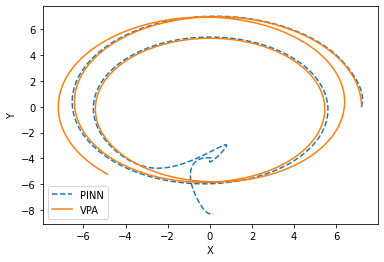

Epoch [10100/24000], Loss: 277.1,   LOSS_function: 252.1,   LOSS_E:0.0002997,    LOSS_initial: 0.0008538,
lamda1:1.001,    lamda2:6.037e+04,    lamda3:7779,      learn rate:0.001077,    time: 889.8303303718567
loss_compared with real:0.29761,   miu_train:0.004121,    lossmean:0.242
Epoch [10200/24000], Loss: 105.7,   LOSS_function: 76.98,   LOSS_E:0.0001963,    LOSS_initial: 0.002154,
lamda1:1.001,    lamda2:6.037e+04,    lamda3:7779,      learn rate:0.001077,    time: 898.5296456813812
loss_compared with real:0.30149,   miu_train:0.0046,    lossmean:0.2328
Epoch [10300/24000], Loss: 131.2,   LOSS_function: 32.98,   LOSS_E:0.0003701,    LOSS_initial: 0.009753,
lamda1:1.001,    lamda2:6.037e+04,    lamda3:7779,      learn rate:0.001077,    time: 906.9812228679657
loss_compared with real:0.28325,   miu_train:0.00569,    lossmean:0.3477
Epoch [10400/24000], Loss: 387.2,   LOSS_function: 280.6,   LOSS_E:0.000784,    LOSS_initial: 0.007573,
lamda1:1.001,    lamda2:6.037e+04,    lamda3:7779,

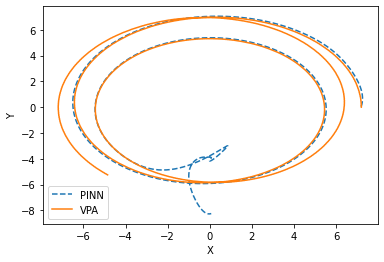

Epoch [10600/24000], Loss: 48.1,   LOSS_function: 29.07,   LOSS_E:0.0001104,    LOSS_initial: 0.001585,
lamda1:1.001,    lamda2:6.037e+04,    lamda3:7779,      learn rate:0.001077,    time: 937.6590197086334
loss_compared with real:0.27526,   miu_train:0.00469,    lossmean:0.1403
Epoch [10700/24000], Loss: 90.51,   LOSS_function: 31.23,   LOSS_E:0.0001546,    LOSS_initial: 0.006416,
lamda1:1.001,    lamda2:6.037e+04,    lamda3:7779,      learn rate:0.001077,    time: 947.6272664070129
loss_compared with real:0.26283,   miu_train:0.004621,    lossmean:0.2038
Epoch [10800/24000], Loss: 163,   LOSS_function: 97.14,   LOSS_E:0.0006685,    LOSS_initial: 0.003266,
lamda1:1.001,    lamda2:6.037e+04,    lamda3:7779,      learn rate:0.001077,    time: 957.5019798278809
loss_compared with real:0.2061,   miu_train:0.005043,    lossmean:0.2055
Epoch [10900/24000], Loss: 184.4,   LOSS_function: 140.9,   LOSS_E:0.0002515,    LOSS_initial: 0.003616,
lamda1:1.001,    lamda2:6.037e+04,    lamda3:7779, 

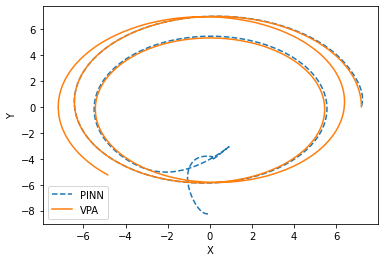

Epoch [11100/24000], Loss: 51.3,   LOSS_function: 17.24,   LOSS_E:0.0002928,    LOSS_initial: 0.003052,
lamda1:1.001,    lamda2:4.84e+04,    lamda3:6513,      learn rate:0.001013,    time: 989.0177500247955
loss_compared with real:0.18511,   miu_train:0.004625,    lossmean:0.09068
Epoch [11200/24000], Loss: 156.3,   LOSS_function: 10.69,   LOSS_E:0.0003741,    LOSS_initial: 0.01958,
lamda1:1.001,    lamda2:4.84e+04,    lamda3:6513,      learn rate:0.001013,    time: 999.4411706924438
loss_compared with real:0.15794,   miu_train:0.004101,    lossmean:0.1418
Epoch [11300/24000], Loss: 120.6,   LOSS_function: 34.86,   LOSS_E:0.001164,    LOSS_initial: 0.0045,
lamda1:1.001,    lamda2:4.84e+04,    lamda3:6513,      learn rate:0.001013,    time: 1009.748108625412
loss_compared with real:0.13374,   miu_train:0.005224,    lossmean:0.1299
Epoch [11400/24000], Loss: 38.14,   LOSS_function: 19.66,   LOSS_E:0.0002724,    LOSS_initial: 0.0008091,
lamda1:1.001,    lamda2:4.84e+04,    lamda3:6513,   

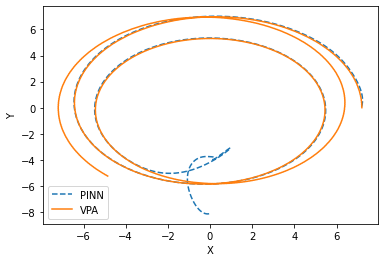

Epoch [11600/24000], Loss: 356.2,   LOSS_function: 327.1,   LOSS_E:0.0003304,    LOSS_initial: 0.001978,
lamda1:1.001,    lamda2:4.84e+04,    lamda3:6513,      learn rate:0.001013,    time: 1042.0856847763062
loss_compared with real:0.14356,   miu_train:0.004,    lossmean:0.2203
Epoch [11700/24000], Loss: 199.1,   LOSS_function: 34.62,   LOSS_E:0.0003649,    LOSS_initial: 0.02254,
lamda1:1.001,    lamda2:4.84e+04,    lamda3:6513,      learn rate:0.001013,    time: 1052.1442697048187
loss_compared with real:0.18316,   miu_train:0.004529,    lossmean:0.1518
Epoch [11800/24000], Loss: 84.54,   LOSS_function: 26.8,   LOSS_E:0.000246,    LOSS_initial: 0.007034,
lamda1:1.001,    lamda2:4.84e+04,    lamda3:6513,      learn rate:0.001013,    time: 1062.5881247520447
loss_compared with real:0.19866,   miu_train:0.004428,    lossmean:0.1065
Epoch [11900/24000], Loss: 44.9,   LOSS_function: 20.26,   LOSS_E:0.0001963,    LOSS_initial: 0.00232,
lamda1:1.001,    lamda2:4.84e+04,    lamda3:6513,     

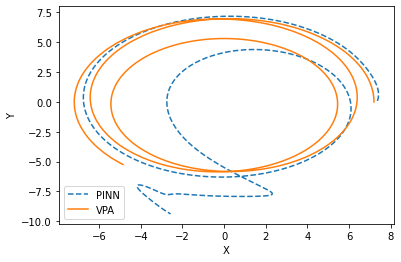

Epoch [12100/24000], Loss: 4214,   LOSS_function: 3407,   LOSS_E:0.01199,    LOSS_initial: 0.008255,
lamda1:1,    lamda2:6.22e+04,    lamda3:7275,      learn rate:0.0009518,    time: 1095.5989246368408
loss_compared with real:90.981,   miu_train:0.06404,    lossmean:0.3101
Epoch [12200/24000], Loss: 1826,   LOSS_function: 1666,   LOSS_E:0.002456,    LOSS_initial: 0.0008508,
lamda1:1,    lamda2:6.22e+04,    lamda3:7275,      learn rate:0.0009518,    time: 1106.2529604434967
loss_compared with real:69.311,   miu_train:0.02842,    lossmean:-0.9591
Epoch [12300/24000], Loss: 995.5,   LOSS_function: 887.1,   LOSS_E:0.001203,    LOSS_initial: 0.004555,
lamda1:1,    lamda2:6.22e+04,    lamda3:7275,      learn rate:0.0009518,    time: 1116.8366055488586
loss_compared with real:55.675,   miu_train:0.01864,    lossmean:-1.465
Epoch [12400/24000], Loss: 770.2,   LOSS_function: 603,   LOSS_E:0.000849,    LOSS_initial: 0.01569,
lamda1:1,    lamda2:6.22e+04,    lamda3:7275,      learn rate:0.0009518

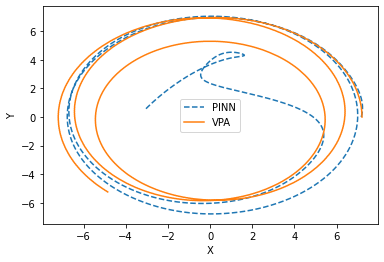

Epoch [12600/24000], Loss: 340.2,   LOSS_function: 304.7,   LOSS_E:0.000407,    LOSS_initial: 0.001376,
lamda1:1,    lamda2:6.22e+04,    lamda3:7275,      learn rate:0.0009518,    time: 1152.5347204208374
loss_compared with real:23.488,   miu_train:0.008006,    lossmean:-1.671
Epoch [12700/24000], Loss: 269.7,   LOSS_function: 200.3,   LOSS_E:0.0003932,    LOSS_initial: 0.006173,
lamda1:1,    lamda2:6.22e+04,    lamda3:7275,      learn rate:0.0009518,    time: 1164.0030567646027
loss_compared with real:16.715,   miu_train:0.006878,    lossmean:-1.482
Epoch [12800/24000], Loss: 323.7,   LOSS_function: 169.4,   LOSS_E:0.0001339,    LOSS_initial: 0.02005,
lamda1:1,    lamda2:6.22e+04,    lamda3:7275,      learn rate:0.0009518,    time: 1174.361243724823
loss_compared with real:12.346,   miu_train:0.005196,    lossmean:-1.347
Epoch [12900/24000], Loss: 167,   LOSS_function: 132.6,   LOSS_E:0.0003698,    LOSS_initial: 0.001551,
lamda1:1,    lamda2:6.22e+04,    lamda3:7275,      learn rate:0

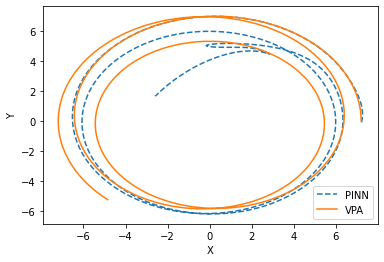

Epoch [13100/24000], Loss: 113.7,   LOSS_function: 95.85,   LOSS_E:0.0001975,    LOSS_initial: 0.001082,
lamda1:1,    lamda2:6.321e+04,    lamda3:4919,      learn rate:0.0008947,    time: 1216.840739250183
loss_compared with real:4.4994,   miu_train:0.004293,    lossmean:-0.8181
Epoch [13200/24000], Loss: 219.8,   LOSS_function: 191.4,   LOSS_E:0.0003442,    LOSS_initial: 0.001324,
lamda1:1,    lamda2:6.321e+04,    lamda3:4919,      learn rate:0.0008947,    time: 1231.5674772262573
loss_compared with real:3.133,   miu_train:0.003786,    lossmean:-0.7406
Epoch [13300/24000], Loss: 144.3,   LOSS_function: 69.41,   LOSS_E:0.0003766,    LOSS_initial: 0.01038,
lamda1:1,    lamda2:6.321e+04,    lamda3:4919,      learn rate:0.0008947,    time: 1242.5969178676605
loss_compared with real:2.285,   miu_train:0.003637,    lossmean:-0.6858
Epoch [13400/24000], Loss: 55.66,   LOSS_function: 36.85,   LOSS_E:9.348e-05,    LOSS_initial: 0.00262,
lamda1:1,    lamda2:6.321e+04,    lamda3:4919,      learn

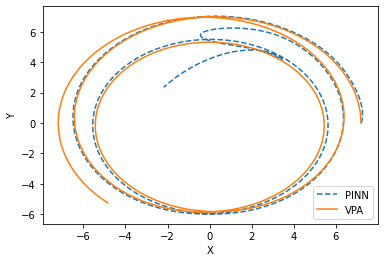

Epoch [13600/24000], Loss: 402.8,   LOSS_function: 344.9,   LOSS_E:0.0002094,    LOSS_initial: 0.009052,
lamda1:1,    lamda2:6.321e+04,    lamda3:4919,      learn rate:0.0008947,    time: 1276.838743686676
loss_compared with real:0.77873,   miu_train:0.003248,    lossmean:-0.3063
Epoch [13700/24000], Loss: 91.93,   LOSS_function: 48.46,   LOSS_E:0.000466,    LOSS_initial: 0.002845,
lamda1:1,    lamda2:6.321e+04,    lamda3:4919,      learn rate:0.0008947,    time: 1287.8208096027374
loss_compared with real:0.5683,   miu_train:0.003713,    lossmean:-0.2994
Epoch [13800/24000], Loss: 66.09,   LOSS_function: 15.8,   LOSS_E:0.0002263,    LOSS_initial: 0.007314,
lamda1:1,    lamda2:6.321e+04,    lamda3:4919,      learn rate:0.0008947,    time: 1299.2412605285645
loss_compared with real:0.36132,   miu_train:0.003243,    lossmean:-0.1749
Epoch [13900/24000], Loss: 128.9,   LOSS_function: 37.64,   LOSS_E:0.0002099,    LOSS_initial: 0.01586,
lamda1:1,    lamda2:6.321e+04,    lamda3:4919,      le

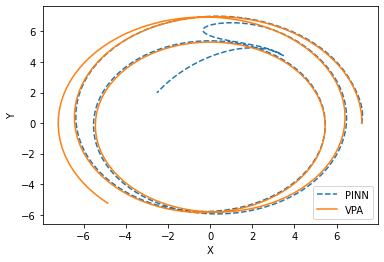

Epoch [14100/24000], Loss: 50.72,   LOSS_function: 33.59,   LOSS_E:7.935e-05,    LOSS_initial: 0.003452,
lamda1:1,    lamda2:5.88e+04,    lamda3:3606,      learn rate:0.000841,    time: 1336.6066298484802
loss_compared with real:0.12919,   miu_train:0.003389,    lossmean:-0.1004
Epoch [14200/24000], Loss: 273,   LOSS_function: 115.5,   LOSS_E:0.0002274,    LOSS_initial: 0.03996,
lamda1:1,    lamda2:5.88e+04,    lamda3:3606,      learn rate:0.000841,    time: 1348.468496799469
loss_compared with real:0.11523,   miu_train:0.002653,    lossmean:-0.04822
Epoch [14300/24000], Loss: 61.35,   LOSS_function: 21.38,   LOSS_E:0.0001706,    LOSS_initial: 0.008298,
lamda1:1,    lamda2:5.88e+04,    lamda3:3606,      learn rate:0.000841,    time: 1360.2477831840515
loss_compared with real:0.086405,   miu_train:0.003149,    lossmean:-0.01455
Epoch [14400/24000], Loss: 9,   LOSS_function: 4.687,   LOSS_E:5.9e-05,    LOSS_initial: 0.0002334,
lamda1:1,    lamda2:5.88e+04,    lamda3:3606,      learn rate

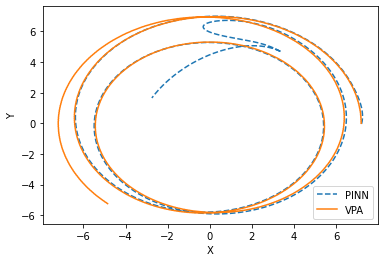

Epoch [14600/24000], Loss: 45.81,   LOSS_function: 12.2,   LOSS_E:9.538e-05,    LOSS_initial: 0.007763,
lamda1:1,    lamda2:5.88e+04,    lamda3:3606,      learn rate:0.000841,    time: 1396.922358751297
loss_compared with real:0.068105,   miu_train:0.003438,    lossmean:0.02486
Epoch [14700/24000], Loss: 40.24,   LOSS_function: 10.3,   LOSS_E:7.922e-05,    LOSS_initial: 0.00701,
lamda1:1,    lamda2:5.88e+04,    lamda3:3606,      learn rate:0.000841,    time: 1408.5337719917297
loss_compared with real:0.034503,   miu_train:0.003275,    lossmean:0.02554
Epoch [14800/24000], Loss: 108.7,   LOSS_function: 96.66,   LOSS_E:0.0001612,    LOSS_initial: 0.0006986,
lamda1:1,    lamda2:5.88e+04,    lamda3:3606,      learn rate:0.000841,    time: 1420.0351150035858
loss_compared with real:0.045957,   miu_train:0.003527,    lossmean:0.08321
Epoch [14900/24000], Loss: 154.1,   LOSS_function: 19.77,   LOSS_E:0.0004431,    LOSS_initial: 0.03004,
lamda1:1,    lamda2:5.88e+04,    lamda3:3606,      learn

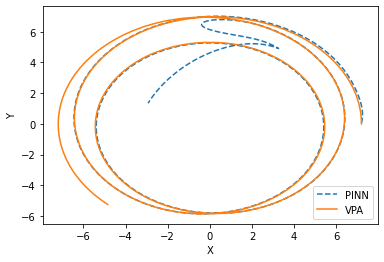

Epoch [15100/24000], Loss: 35.21,   LOSS_function: 9.377,   LOSS_E:0.0002711,    LOSS_initial: 0.003352,
lamda1:1,    lamda2:5.88e+04,    lamda3:2950,      learn rate:0.0007906,    time: 1455.5533397197723
loss_compared with real:0.077358,   miu_train:0.00323,    lossmean:0.02754
Epoch [15200/24000], Loss: 77.89,   LOSS_function: 22.32,   LOSS_E:0.0004158,    LOSS_initial: 0.01055,
lamda1:1,    lamda2:5.88e+04,    lamda3:2950,      learn rate:0.0007906,    time: 1466.006412267685
loss_compared with real:0.031682,   miu_train:0.002872,    lossmean:0.03619
Epoch [15300/24000], Loss: 26.69,   LOSS_function: 16.24,   LOSS_E:0.000104,    LOSS_initial: 0.001469,
lamda1:1,    lamda2:5.88e+04,    lamda3:2950,      learn rate:0.0007906,    time: 1477.5644690990448
loss_compared with real:0.028933,   miu_train:0.003339,    lossmean:0.01186
Epoch [15400/24000], Loss: 36.32,   LOSS_function: 12.19,   LOSS_E:0.0001642,    LOSS_initial: 0.004901,
lamda1:1,    lamda2:5.88e+04,    lamda3:2950,      le

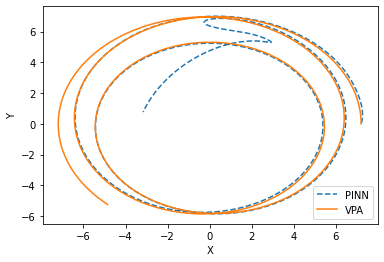

Epoch [15600/24000], Loss: 181.6,   LOSS_function: 109.3,   LOSS_E:0.0006696,    LOSS_initial: 0.01114,
lamda1:1,    lamda2:5.88e+04,    lamda3:2950,      learn rate:0.0007906,    time: 1512.8692362308502
loss_compared with real:0.033058,   miu_train:0.00332,    lossmean:-0.0009269
Epoch [15700/24000], Loss: 104.4,   LOSS_function: 58.46,   LOSS_E:0.000395,    LOSS_initial: 0.007704,
lamda1:1,    lamda2:5.88e+04,    lamda3:2950,      learn rate:0.0007906,    time: 1523.9332206249237
loss_compared with real:0.05132,   miu_train:0.00368,    lossmean:0.06731
Epoch [15800/24000], Loss: 89.55,   LOSS_function: 44.26,   LOSS_E:0.0004867,    LOSS_initial: 0.005645,
lamda1:1,    lamda2:5.88e+04,    lamda3:2950,      learn rate:0.0007906,    time: 1535.1069927215576
loss_compared with real:0.045849,   miu_train:0.003645,    lossmean:0.08825
Epoch [15900/24000], Loss: 651.8,   LOSS_function: 471.3,   LOSS_E:0.003027,    LOSS_initial: 0.0007973,
lamda1:1,    lamda2:5.88e+04,    lamda3:2950,      

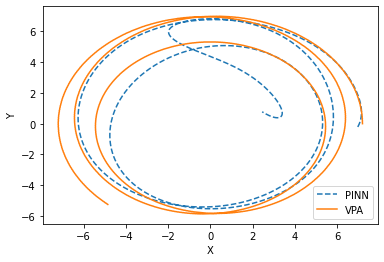

Epoch [16100/24000], Loss: 3638,   LOSS_function: 3019,   LOSS_E:0.008914,    LOSS_initial: 0.04313,
lamda1:1,    lamda2:5.659e+04,    lamda3:2622,      learn rate:0.0007431,    time: 1570.560239315033
loss_compared with real:114.21,   miu_train:0.06142,    lossmean:-2.055
Epoch [16200/24000], Loss: 2415,   LOSS_function: 1936,   LOSS_E:0.007342,    LOSS_initial: 0.02415,
lamda1:1,    lamda2:5.659e+04,    lamda3:2622,      learn rate:0.0007431,    time: 1582.5150091648102
loss_compared with real:104.15,   miu_train:0.03588,    lossmean:-1.474
Epoch [16300/24000], Loss: 1867,   LOSS_function: 1654,   LOSS_E:0.002487,    LOSS_initial: 0.02732,
lamda1:1,    lamda2:5.659e+04,    lamda3:2622,      learn rate:0.0007431,    time: 1595.0543479919434
loss_compared with real:88.383,   miu_train:0.02279,    lossmean:-0.6611
Epoch [16400/24000], Loss: 958.8,   LOSS_function: 825.2,   LOSS_E:0.002158,    LOSS_initial: 0.004236,
lamda1:1,    lamda2:5.659e+04,    lamda3:2622,      learn rate:0.000743

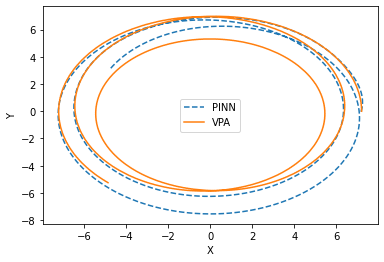

Epoch [16600/24000], Loss: 279.1,   LOSS_function: 221,   LOSS_E:0.0008732,    LOSS_initial: 0.003283,
lamda1:1,    lamda2:5.659e+04,    lamda3:2622,      learn rate:0.0007431,    time: 1632.1676959991455
loss_compared with real:18.536,   miu_train:0.005003,    lossmean:0.5052
Epoch [16700/24000], Loss: 173.8,   LOSS_function: 126.4,   LOSS_E:0.0004032,    LOSS_initial: 0.009387,
lamda1:1,    lamda2:5.659e+04,    lamda3:2622,      learn rate:0.0007431,    time: 1643.7526786327362
loss_compared with real:8.8889,   miu_train:0.004256,    lossmean:0.5353
Epoch [16800/24000], Loss: 329.1,   LOSS_function: 203.5,   LOSS_E:0.0005101,    LOSS_initial: 0.03688,
lamda1:1,    lamda2:5.659e+04,    lamda3:2622,      learn rate:0.0007431,    time: 1655.7475235462189
loss_compared with real:4.3682,   miu_train:0.002787,    lossmean:0.4781
Epoch [16900/24000], Loss: 710.5,   LOSS_function: 662.4,   LOSS_E:0.0002804,    LOSS_initial: 0.01219,
lamda1:1,    lamda2:5.659e+04,    lamda3:2622,      learn r

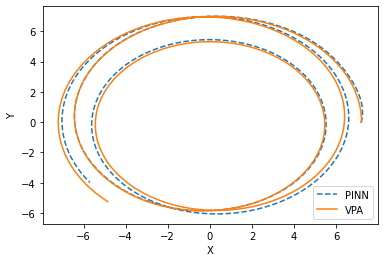

Epoch [17100/24000], Loss: 535,   LOSS_function: 499.7,   LOSS_E:0.0001461,    LOSS_initial: 0.01098,
lamda1:1,    lamda2:5.549e+04,    lamda3:2458,      learn rate:0.0006986,    time: 1692.13849234581
loss_compared with real:0.49934,   miu_train:0.002196,    lossmean:0.2322
Epoch [17200/24000], Loss: 28.26,   LOSS_function: 14.56,   LOSS_E:0.0001767,    LOSS_initial: 0.001581,
lamda1:1,    lamda2:5.549e+04,    lamda3:2458,      learn rate:0.0006986,    time: 1703.9635972976685
loss_compared with real:0.30274,   miu_train:0.00294,    lossmean:0.2383
Epoch [17300/24000], Loss: 45.1,   LOSS_function: 13.88,   LOSS_E:0.0001765,    LOSS_initial: 0.00871,
lamda1:1,    lamda2:5.549e+04,    lamda3:2458,      learn rate:0.0006986,    time: 1715.9388692378998
loss_compared with real:0.14835,   miu_train:0.002133,    lossmean:0.161
Epoch [17400/24000], Loss: 27.46,   LOSS_function: 7.484,   LOSS_E:0.0001031,    LOSS_initial: 0.005797,
lamda1:1,    lamda2:5.549e+04,    lamda3:2458,      learn rat

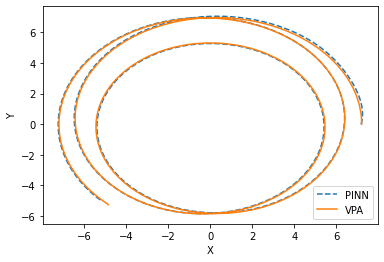

Epoch [17600/24000], Loss: 36.43,   LOSS_function: 18.73,   LOSS_E:0.0002154,    LOSS_initial: 0.002336,
lamda1:1,    lamda2:5.549e+04,    lamda3:2458,      learn rate:0.0006986,    time: 1751.4183173179626
loss_compared with real:0.094014,   miu_train:0.003145,    lossmean:0.1389
Epoch [17700/24000], Loss: 346.4,   LOSS_function: 240,   LOSS_E:0.0001656,    LOSS_initial: 0.03949,
lamda1:1,    lamda2:5.549e+04,    lamda3:2458,      learn rate:0.0006986,    time: 1762.2419273853302
loss_compared with real:0.065164,   miu_train:0.002177,    lossmean:0.09267
Epoch [17800/24000], Loss: 114.4,   LOSS_function: 36.22,   LOSS_E:0.0005606,    LOSS_initial: 0.01913,
lamda1:1,    lamda2:5.549e+04,    lamda3:2458,      learn rate:0.0006986,    time: 1773.6329534053802
loss_compared with real:0.071896,   miu_train:0.002733,    lossmean:0.1343
Epoch [17900/24000], Loss: 43.81,   LOSS_function: 12.95,   LOSS_E:0.0001311,    LOSS_initial: 0.009594,
lamda1:1,    lamda2:5.549e+04,    lamda3:2458,      

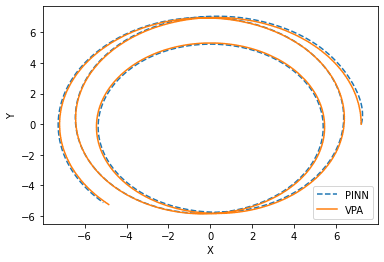

Epoch [18100/24000], Loss: 587.5,   LOSS_function: 548.4,   LOSS_E:9.098e-05,    LOSS_initial: 0.01423,
lamda1:1,    lamda2:5.549e+04,    lamda3:2376,      learn rate:0.0006566,    time: 1812.619435787201
loss_compared with real:0.059033,   miu_train:0.001926,    lossmean:0.07343
Epoch [18200/24000], Loss: 30.71,   LOSS_function: 6.936,   LOSS_E:0.0001189,    LOSS_initial: 0.007226,
lamda1:1,    lamda2:5.549e+04,    lamda3:2376,      learn rate:0.0006566,    time: 1825.3380694389343
loss_compared with real:0.054821,   miu_train:0.002702,    lossmean:0.09796
Epoch [18300/24000], Loss: 135.8,   LOSS_function: 88.4,   LOSS_E:0.0004723,    LOSS_initial: 0.008896,
lamda1:1,    lamda2:5.549e+04,    lamda3:2376,      learn rate:0.0006566,    time: 1837.7828149795532
loss_compared with real:0.071806,   miu_train:0.002324,    lossmean:0.1231
Epoch [18400/24000], Loss: 414.9,   LOSS_function: 163.9,   LOSS_E:0.004481,    LOSS_initial: 0.0009613,
lamda1:1,    lamda2:5.549e+04,    lamda3:2376,    

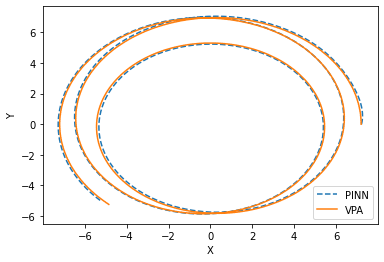

Epoch [18600/24000], Loss: 347.9,   LOSS_function: 321.7,   LOSS_E:0.0002304,    LOSS_initial: 0.005582,
lamda1:1,    lamda2:5.549e+04,    lamda3:2376,      learn rate:0.0006566,    time: 1875.462468624115
loss_compared with real:0.06034,   miu_train:0.002096,    lossmean:0.08471
Epoch [18700/24000], Loss: 99.26,   LOSS_function: 13.28,   LOSS_E:0.0001869,    LOSS_initial: 0.03181,
lamda1:1,    lamda2:5.549e+04,    lamda3:2376,      learn rate:0.0006566,    time: 1888.3570339679718
loss_compared with real:0.073425,   miu_train:0.002494,    lossmean:0.09886
Epoch [18800/24000], Loss: 85.03,   LOSS_function: 10.66,   LOSS_E:0.0005501,    LOSS_initial: 0.01845,
lamda1:1,    lamda2:5.549e+04,    lamda3:2376,      learn rate:0.0006566,    time: 1901.3369688987732
loss_compared with real:0.057589,   miu_train:0.00229,    lossmean:0.04342
Epoch [18900/24000], Loss: 22.22,   LOSS_function: 10.31,   LOSS_E:6.992e-05,    LOSS_initial: 0.003379,
lamda1:1,    lamda2:5.549e+04,    lamda3:2376,     

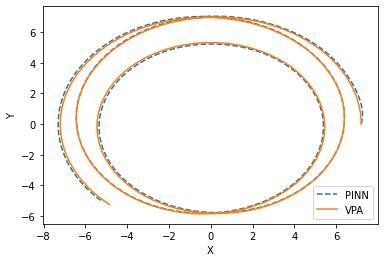

Epoch [19100/24000], Loss: 22.38,   LOSS_function: 11.7,   LOSS_E:0.0001079,    LOSS_initial: 0.002033,
lamda1:1,    lamda2:5.493e+04,    lamda3:2335,      learn rate:0.0006172,    time: 1941.0513663291931
loss_compared with real:0.087137,   miu_train:0.002541,    lossmean:0.08679
Epoch [19200/24000], Loss: 65.65,   LOSS_function: 22.99,   LOSS_E:0.0001721,    LOSS_initial: 0.01421,
lamda1:1,    lamda2:5.493e+04,    lamda3:2335,      learn rate:0.0006172,    time: 1954.3596408367157
loss_compared with real:0.063502,   miu_train:0.002298,    lossmean:0.0516
Epoch [19300/24000], Loss: 137.3,   LOSS_function: 24.51,   LOSS_E:0.0007128,    LOSS_initial: 0.03152,
lamda1:1,    lamda2:5.493e+04,    lamda3:2335,      learn rate:0.0006172,    time: 1967.160810470581
loss_compared with real:0.046308,   miu_train:0.002625,    lossmean:0.04338
Epoch [19400/24000], Loss: 42.5,   LOSS_function: 14.95,   LOSS_E:0.0002264,    LOSS_initial: 0.006468,
lamda1:1,    lamda2:5.493e+04,    lamda3:2335,      

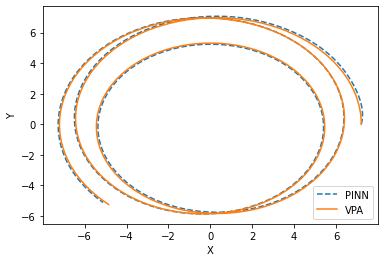

Epoch [19600/24000], Loss: 29.67,   LOSS_function: 10.79,   LOSS_E:6.485e-05,    LOSS_initial: 0.006559,
lamda1:1,    lamda2:5.493e+04,    lamda3:2335,      learn rate:0.0006172,    time: 2007.71320104599
loss_compared with real:0.052115,   miu_train:0.002243,    lossmean:0.09603
Epoch [19700/24000], Loss: 69.69,   LOSS_function: 25.29,   LOSS_E:0.0001919,    LOSS_initial: 0.01449,
lamda1:1,    lamda2:5.493e+04,    lamda3:2335,      learn rate:0.0006172,    time: 2020.5395481586456
loss_compared with real:0.07217,   miu_train:0.002509,    lossmean:0.07802
Epoch [19800/24000], Loss: 40.48,   LOSS_function: 19.08,   LOSS_E:0.0002074,    LOSS_initial: 0.00428,
lamda1:1,    lamda2:5.493e+04,    lamda3:2335,      learn rate:0.0006172,    time: 2035.6300776004791
loss_compared with real:0.047172,   miu_train:0.0025,    lossmean:0.06471
Epoch [19900/24000], Loss: 142.4,   LOSS_function: 42.68,   LOSS_E:0.0002278,    LOSS_initial: 0.03733,
lamda1:1,    lamda2:5.493e+04,    lamda3:2335,      le

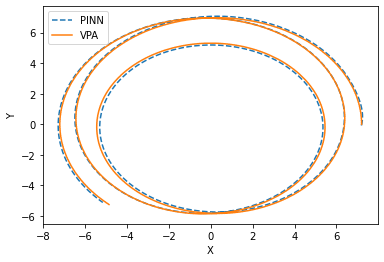

Epoch [20100/24000], Loss: 21.21,   LOSS_function: 8.924,   LOSS_E:1.833e-05,    LOSS_initial: 0.004874,
lamda1:1,    lamda2:5.466e+04,    lamda3:2315,      learn rate:0.000116,    time: 2071.558893442154
loss_compared with real:0.052473,   miu_train:0.002262,    lossmean:0.09109
Epoch [20200/24000], Loss: 21.24,   LOSS_function: 8.28,   LOSS_E:6.111e-05,    LOSS_initial: 0.004155,
lamda1:1,    lamda2:5.466e+04,    lamda3:2315,      learn rate:0.000116,    time: 2083.137888431549
loss_compared with real:0.041178,   miu_train:0.002695,    lossmean:0.09914
Epoch [20300/24000], Loss: 28.32,   LOSS_function: 23.77,   LOSS_E:1.859e-05,    LOSS_initial: 0.001521,
lamda1:1,    lamda2:5.466e+04,    lamda3:2315,      learn rate:0.000116,    time: 2095.558534145355
loss_compared with real:0.047639,   miu_train:0.002561,    lossmean:0.09051
Epoch [20400/24000], Loss: 2.962,   LOSS_function: 1.841,   LOSS_E:1.618e-05,    LOSS_initial: 0.000102,
lamda1:1,    lamda2:5.466e+04,    lamda3:2315,      l

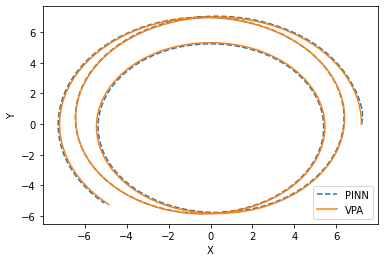

Epoch [20600/24000], Loss: 9.138,   LOSS_function: 1.321,   LOSS_E:7.219e-05,    LOSS_initial: 0.001672,
lamda1:1,    lamda2:5.466e+04,    lamda3:2315,      learn rate:0.000116,    time: 2137.982533931732
loss_compared with real:0.039307,   miu_train:0.00255,    lossmean:0.06426
Epoch [20700/24000], Loss: 80,   LOSS_function: 68.19,   LOSS_E:4.593e-05,    LOSS_initial: 0.004004,
lamda1:1,    lamda2:5.466e+04,    lamda3:2315,      learn rate:0.000116,    time: 2151.432195186615
loss_compared with real:0.041552,   miu_train:0.002617,    lossmean:0.07521
Epoch [20800/24000], Loss: 12.2,   LOSS_function: 7.099,   LOSS_E:4.719e-05,    LOSS_initial: 0.001088,
lamda1:1,    lamda2:5.466e+04,    lamda3:2315,      learn rate:0.000116,    time: 2165.474812746048
loss_compared with real:0.043644,   miu_train:0.002722,    lossmean:0.09352
Epoch [20900/24000], Loss: 21.29,   LOSS_function: 3.202,   LOSS_E:2.915e-05,    LOSS_initial: 0.007123,
lamda1:1,    lamda2:5.466e+04,    lamda3:2315,      learn

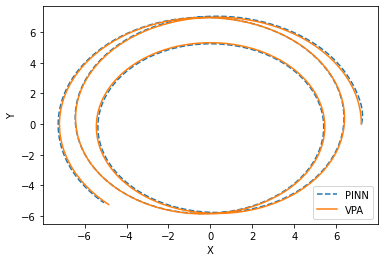

Epoch [21100/24000], Loss: 9.576,   LOSS_function: 6.929,   LOSS_E:2.264e-05,    LOSS_initial: 0.0006105,
lamda1:1,    lamda2:5.466e+04,    lamda3:2305,      learn rate:0.0001091,    time: 2206.8387422561646
loss_compared with real:0.037149,   miu_train:0.002531,    lossmean:0.06986
Epoch [21200/24000], Loss: 102,   LOSS_function: 77.31,   LOSS_E:2.449e-05,    LOSS_initial: 0.01013,
lamda1:1,    lamda2:5.466e+04,    lamda3:2305,      learn rate:0.0001091,    time: 2220.5659148693085
loss_compared with real:0.041477,   miu_train:0.002098,    lossmean:0.08049
Epoch [21300/24000], Loss: 8.161,   LOSS_function: 3.382,   LOSS_E:2.473e-05,    LOSS_initial: 0.001486,
lamda1:1,    lamda2:5.466e+04,    lamda3:2305,      learn rate:0.0001091,    time: 2234.885495901108
loss_compared with real:0.05205,   miu_train:0.002665,    lossmean:0.08438
Epoch [21400/24000], Loss: 12.15,   LOSS_function: 7.331,   LOSS_E:2.658e-05,    LOSS_initial: 0.001461,
lamda1:1,    lamda2:5.466e+04,    lamda3:2305,    

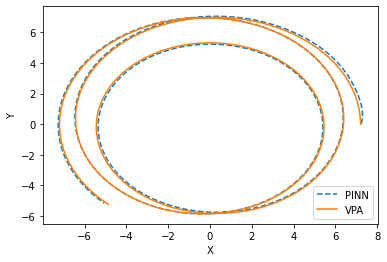

Epoch [21600/24000], Loss: 10.86,   LOSS_function: 1.457,   LOSS_E:6.796e-05,    LOSS_initial: 0.002468,
lamda1:1,    lamda2:5.466e+04,    lamda3:2305,      learn rate:0.0001091,    time: 2276.4661407470703
loss_compared with real:0.039418,   miu_train:0.002751,    lossmean:0.08754
Epoch [21700/24000], Loss: 6.451,   LOSS_function: 4.339,   LOSS_E:2.987e-05,    LOSS_initial: 0.000207,
lamda1:1,    lamda2:5.466e+04,    lamda3:2305,      learn rate:0.0001091,    time: 2290.0682468414307
loss_compared with real:0.035721,   miu_train:0.002601,    lossmean:0.07696
Epoch [21800/24000], Loss: 42.27,   LOSS_function: 32.25,   LOSS_E:2.247e-05,    LOSS_initial: 0.003805,
lamda1:1,    lamda2:5.466e+04,    lamda3:2305,      learn rate:0.0001091,    time: 2303.197756290436
loss_compared with real:0.03995,   miu_train:0.00258,    lossmean:0.05038
Epoch [21900/24000], Loss: 10.47,   LOSS_function: 2.148,   LOSS_E:4.069e-05,    LOSS_initial: 0.002647,
lamda1:1,    lamda2:5.466e+04,    lamda3:2305,   

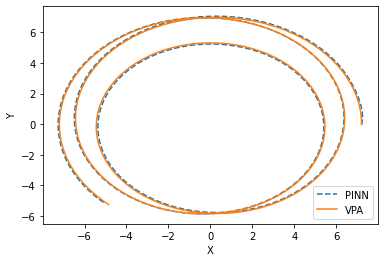

Epoch [22100/24000], Loss: 633.1,   LOSS_function: 626.4,   LOSS_E:1.917e-05,    LOSS_initial: 0.002315,
lamda1:1,    lamda2:5.466e+04,    lamda3:2299,      learn rate:0.0001025,    time: 2346.146422624588
loss_compared with real:0.034761,   miu_train:0.002341,    lossmean:0.0514
Epoch [22200/24000], Loss: 6.403,   LOSS_function: 2.274,   LOSS_E:3.495e-05,    LOSS_initial: 0.0009644,
lamda1:1,    lamda2:5.466e+04,    lamda3:2299,      learn rate:0.0001025,    time: 2359.270107269287
loss_compared with real:0.048726,   miu_train:0.002626,    lossmean:0.08025
Epoch [22300/24000], Loss: 10.53,   LOSS_function: 3.457,   LOSS_E:3.322e-05,    LOSS_initial: 0.002284,
lamda1:1,    lamda2:5.466e+04,    lamda3:2299,      learn rate:0.0001025,    time: 2371.833092212677
loss_compared with real:0.05122,   miu_train:0.002489,    lossmean:0.07724
Epoch [22400/24000], Loss: 20.37,   LOSS_function: 12.38,   LOSS_E:3.129e-05,    LOSS_initial: 0.002727,
lamda1:1,    lamda2:5.466e+04,    lamda3:2299,    

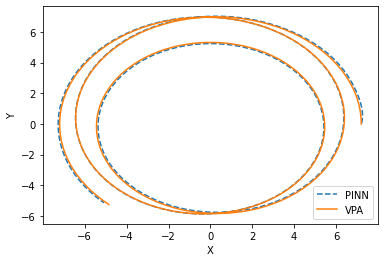

Epoch [22600/24000], Loss: 11.07,   LOSS_function: 1.529,   LOSS_E:1.281e-05,    LOSS_initial: 0.003846,
lamda1:1,    lamda2:5.466e+04,    lamda3:2299,      learn rate:0.0001025,    time: 2412.23943066597
loss_compared with real:0.032934,   miu_train:0.00265,    lossmean:0.08094
Epoch [22700/24000], Loss: 19.23,   LOSS_function: 2.892,   LOSS_E:4.208e-05,    LOSS_initial: 0.006103,
lamda1:1,    lamda2:5.466e+04,    lamda3:2299,      learn rate:0.0001025,    time: 2426.6857233047485
loss_compared with real:0.040405,   miu_train:0.002445,    lossmean:0.08571
Epoch [22800/24000], Loss: 31.6,   LOSS_function: 3.847,   LOSS_E:3.606e-05,    LOSS_initial: 0.01121,
lamda1:1,    lamda2:5.466e+04,    lamda3:2299,      learn rate:0.0001025,    time: 2441.5803089141846
loss_compared with real:0.023887,   miu_train:0.002336,    lossmean:0.07199
Epoch [22900/24000], Loss: 12.89,   LOSS_function: 9.456,   LOSS_E:2.211e-05,    LOSS_initial: 0.0009647,
lamda1:1,    lamda2:5.466e+04,    lamda3:2299,    

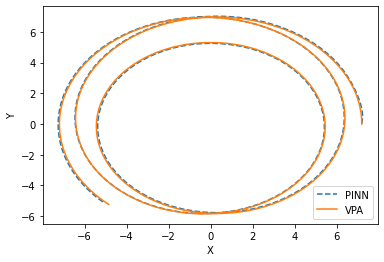

Epoch [23100/24000], Loss: 20.24,   LOSS_function: 5.077,   LOSS_E:0.000113,    LOSS_initial: 0.00392,
lamda1:1,    lamda2:5.452e+04,    lamda3:2297,      learn rate:9.638e-05,    time: 2485.350958585739
loss_compared with real:0.043043,   miu_train:0.002831,    lossmean:0.07222
Epoch [23200/24000], Loss: 8.038,   LOSS_function: 2.746,   LOSS_E:1.967e-05,    LOSS_initial: 0.001836,
lamda1:1,    lamda2:5.452e+04,    lamda3:2297,      learn rate:9.638e-05,    time: 2499.8300728797913
loss_compared with real:0.046873,   miu_train:0.002498,    lossmean:0.1056
Epoch [23300/24000], Loss: 86.84,   LOSS_function: 4.314,   LOSS_E:5.893e-05,    LOSS_initial: 0.03453,
lamda1:1,    lamda2:5.452e+04,    lamda3:2297,      learn rate:9.638e-05,    time: 2514.141448020935
loss_compared with real:0.041277,   miu_train:0.002133,    lossmean:0.08459
Epoch [23400/24000], Loss: 68.8,   LOSS_function: 66.58,   LOSS_E:1.751e-05,    LOSS_initial: 0.0005353,
lamda1:1,    lamda2:5.452e+04,    lamda3:2297,      

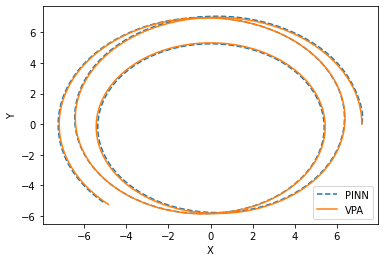

Epoch [23600/24000], Loss: 28.71,   LOSS_function: 10.31,   LOSS_E:7.759e-05,    LOSS_initial: 0.006168,
lamda1:1,    lamda2:5.452e+04,    lamda3:2297,      learn rate:9.638e-05,    time: 2558.0743610858917
loss_compared with real:0.043799,   miu_train:0.002804,    lossmean:0.07022
Epoch [23700/24000], Loss: 15.65,   LOSS_function: 3.964,   LOSS_E:2.264e-05,    LOSS_initial: 0.004548,
lamda1:1,    lamda2:5.452e+04,    lamda3:2297,      learn rate:9.638e-05,    time: 2572.533172607422
loss_compared with real:0.031863,   miu_train:0.002481,    lossmean:0.07165
Epoch [23800/24000], Loss: 12.64,   LOSS_function: 5.655,   LOSS_E:2.684e-05,    LOSS_initial: 0.002401,
lamda1:1,    lamda2:5.452e+04,    lamda3:2297,      learn rate:9.638e-05,    time: 2586.8838181495667
loss_compared with real:0.045075,   miu_train:0.002527,    lossmean:0.08734
Epoch [23900/24000], Loss: 206.4,   LOSS_function: 195.6,   LOSS_E:4.804e-05,    LOSS_initial: 0.003493,
lamda1:1,    lamda2:5.452e+04,    lamda3:2297, 

In [26]:
import time
start_time = time.time()#计时
epochs = 24000  #训练次数
opt = torch.optim.Adam(u.parameters(), lr=learning_rate)

for i in range(epochs):
    opt.zero_grad()
    if i<4000:
        lpde=LOSS1(u)[0]
        lE=LOSS1(u)[1]
        l0=LOSS1(u)[2]
        n_al=10000
        n_real=20
    if i>=4000 and i<8000:
        lpde=LOSS2(u)[0]
        lE=LOSS2(u)[1]
        l0=LOSS2(u)[2]
        n_al=20000
        n_real=40
    if i>=8000 and i<12000:
        lpde=LOSS3(u)[0]
        lE=LOSS3(u)[1]
        l0=LOSS3(u)[2]
        n_al=30000
        n_real=60
    if i>=12000 and i<16000:
        lpde=LOSS4(u)[0]
        lE=LOSS4(u)[1]
        l0=LOSS4(u)[2]
        n_al=40000
        n_real=80
    if i>=16000:
        lpde=LOSS5(u)[0]
        lE=LOSS5(u)[1]
        l0=LOSS5(u)[2]
        n_al=50000
        n_real=100
    if i==20000:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.2
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate
  
    if (i+1)%1000== 0 and (i+1)<15000:
        gradient_lpde=funcweight(lpde)
        gradient_lE=funcweight(lE)
        gradient_l0=funcweight(l0) 

    if (i+1)%1000== 0 and lpde>1e-5:
        lamda1=0.5*lamda1+0.5*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lpde  )
    if (i+1)%1000== 0 and l0>8e-5:
        lamda3=0.5*lamda3+0.5*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_l0  )
    if (i+1)%1000== 0 and lE>8e-5:
        lamda2=0.5*lamda2+0.5*(  (gradient_lpde+gradient_l0+gradient_lE)/gradient_lE  )
        
    l_total=lamda1*lpde+lamda3*l0+lamda2*lE
    l_withoutweight=lpde+l0+lE
    l_total.backward()
    opt.step()
    
    if i%500==0:
        plot_trajectory_during_loop()
    
    if (i+1)%1000 == 0:
        learnr = opt.param_groups[0]['lr']
        
        #更新学习率
        learning_rate *=0.94
        for param_group in opt.param_groups:
            param_group['lr'] = learning_rate
    
    
    

    if (i+1)%n_epoch == 0 or i==0:
        end_time = time.time()
        total_time = end_time - start_time
        learnr = opt.param_groups[0]['lr']
        time_test =torch.arange(interval*jump, interval*(n_al+1+jump), interval*int(n_al/n_real))
        t_test = time_test.view(-1, 1).requires_grad_(True)
        x_test = u(t_test)[:, 0].view(-1, 1)
        y_test = u(t_test)[:, 1].view(-1, 1)
        z_test = u(t_test)[:, 2].view(-1, 1)
        vx_test = gradients(x_test,t_test,1)
        vy_test = gradients(y_test,t_test,1)
        vz_test = gradients(z_test,t_test,1)
        loss_test = loss(x_test,x_real[:(n_real+1)])+loss(y_test,y_real[:(n_real+1)])+loss(z_test,z_real[:(n_real+1)])
        miu_train=funcmiu(x_test,y_test,z_test,vx_test,vy_test,vz_test)
        lossmean_test = torch.sum(x_test-x_real[:(n_real+1)]+y_test-y_real[:(n_real+1)]+z_test-z_real[:(n_real+1)])/n
        print(f'Epoch [{i+1}/{epochs}], Loss: {l_total.item():.4g},   LOSS_function: {lpde.item():.4g},   LOSS_E:{lE.item():.4g},    LOSS_initial: {l0.item():.4g},')
        print(f'lamda1:{lamda1:.4g},    lamda2:{lamda2:.4g},    lamda3:{lamda3:.4g},      learn rate:{learnr:.4g},    time: {total_time}' )
        print(f'loss_compared with real:{loss_test:.5g},   miu_train:{miu_train.mean():.4g},    lossmean:{lossmean_test.item():.4g}') 
        loss_list.append(l_total.item())
        lpde_list.append(lpde.item())
        l0_list.append(l0.item())
        lE_list.append(lE.item())
        lamda1_list.append(lamda1)
        lamda2_list.append(lamda2)
        lamda3_list.append(lamda3)
        l_withoutweight_list.append(l_withoutweight.item())
        time_list.append(total_time)
        loss_test_list.append(loss_test.item())
        lossmean_test_list.append(lossmean_test.item())
        miu_train_list.append(miu_train.mean())
    
    if (i+1)%4000 == 0:
        for name, param in u.named_parameters():
            if 'a' in name:  # 筛选出包含'a'的参数
                print(name, param)
        
        
    if l_total <= stop_condition:#刚才写成loss_test了，感觉不妥，毕竟应该不知道真实数字是多少
        print(f'Training stopped at No.{i+1} time. Loss ({l_total}) is below the specified threshold ({stop_condition}).')
        break


In [27]:
old_uname='hh.pth'
#保存神经网络
torch.save(u.state_dict(), new_prefix + old_uname[2:])

In [28]:
file_lists = [loss_list, lpde_list, l0_list, lE_list, lamda1_list, lamda2_list,lamda3_list,l_withoutweight_list, time_list, loss_test_list, lossmean_test_list,miu_train_list]
file_names = ['hh_loss.txt', 'hh_lpde.txt', 'hh_l0.txt', 'hh_lE.txt', 'hh_lamda1.txt','hh_lamda2.txt', 'hh_lamda3.txt', 'hh_l_withoutweight.txt', 'hh_time.txt', 'hh_loss_test.txt', 'hh_lossmean_test.txt','hh_miu_train_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


In [29]:
#计算神经网络的轨迹
output_history= []#想要缩短周期，就调大Bz
for i in range(jump,(n_all+1+jump),20):
        # 将当前状态输入神经网络得到下一时刻的状态
        next_state = u.forward(torch.tensor([interval*i]) )#+torch.rand(1) * interval )

        # 记录输出值
        output_history.append(next_state)

import numpy as np
x_coordinates = np.array([x[0].item() for x in output_history])
y_coordinates = np.array([x[1].item() for x in output_history])
z_coordinates = np.array([x[2].item() for x in output_history])

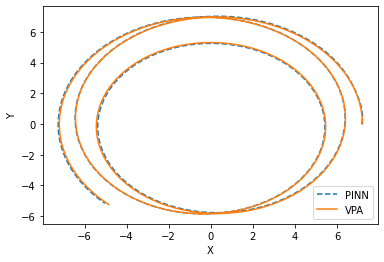

In [30]:
#绘制轨迹，2维
plt.plot(x_coordinates,y_coordinates,linestyle='--', label='PINN')
plt.plot(x_real_plt, y_real_plt,label='VPA')


plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
# plt.title('PINN results VS classic results')
plt.show()

In [31]:
file_lists = [x_coordinates, y_coordinates, z_coordinates]
file_names = ['hh_outputx.txt', 'hh_outputy.txt', 'hh_outputz.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)


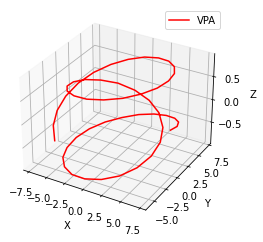

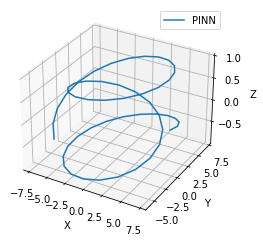

In [32]:
# 绘制轨迹 3维
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_plt[::int(n_all/1000)], y_plt[::int(n_all/1000)] ,z_plt[::int(n_all/1000)],color='red',label='VPA')
#ax.plot(x_coordinates[::int(n_all/100)],y_coordinates[::int(n_all/100)],z_coordinates[::int(n_all/100)],label='neural network')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.plot(x_plt[::int(n_all/100)], y_plt[::int(n_all/100)] ,z_plt[::int(n_all/100)],label='classic computation')
ax.plot(x_coordinates[::int(n_all/1000)],y_coordinates[::int(n_all/1000)],z_coordinates[::int(n_all/1000)],label='PINN')
ax.legend()
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_title('Particle Motion in Electromagnetic Field')
plt.show()

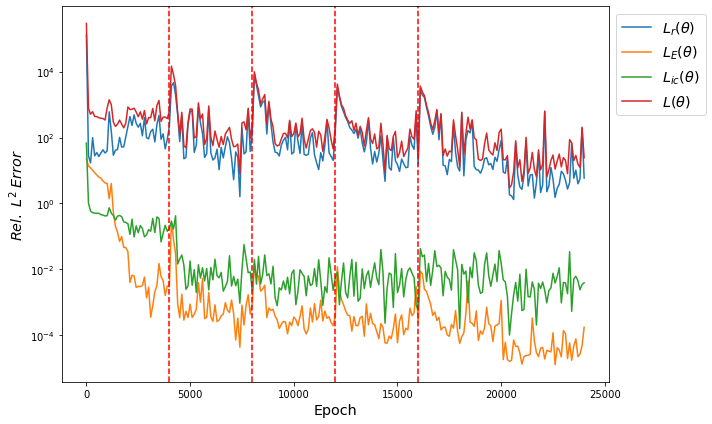

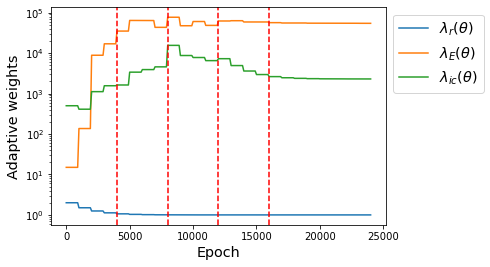

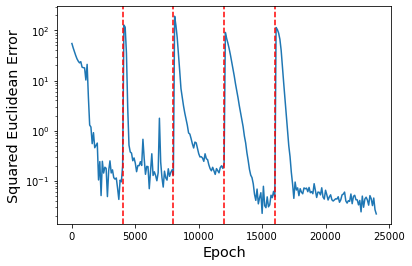

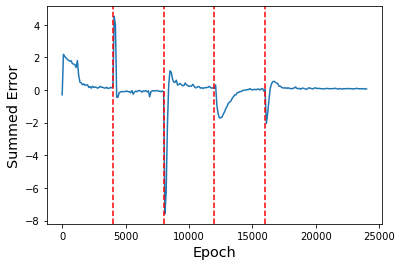

In [33]:
#绘制各loss成分随训练次数epoch变化图
epoch_total = len(loss_list)
epoch_array = np.array(range(0, epoch_total * n_epoch, n_epoch))

plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(epoch_array,lpde_list,label=r'$L_{r}(\theta)$')
#plt.plot(epoch_array,lmiu_list, label='Loss of μ ')
plt.plot(epoch_array,lE_list, label=r'$L_{E}(\theta)$')
plt.plot(epoch_array,l0_list, label=r'$L_{ic}(\theta)$')
plt.plot(epoch_array,loss_list, label=r'$L(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title(r'$Convergence\;of\;rel.\;L^2\;error\;during\;training\;process$')
# 添加图例并设置字体大小，并将其放在图形外部
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))


# 在指定的epoch处绘制红色虚线
epochs_to_mark = [4000,8000,12000,16000]
for epoch in epochs_to_mark:
    plt.axvline(x=epoch, color='red', linestyle='--')
plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()


plt.plot(epoch_array,lamda1_list,label=r'$λ_{r}(\theta)$')
plt.plot(epoch_array,lamda2_list,label=r'$λ_{E}(\theta)$')
plt.plot(epoch_array,lamda3_list,label=r'$λ_{ic}(\theta)$')
#plt.plot(epoch_array,lamda4_list,label='λ for loss of μ')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Adaptive weights', fontsize='x-large')
# plt.title('Adaptive weights during training process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

# 在指定的epoch处绘制红色虚线
epochs_to_mark = [4000,8000,12000,16000]
for epoch in epochs_to_mark:
    plt.axvline(x=epoch, color='red', linestyle='--')
plt.show()#绘图

plt.plot(epoch_array,loss_test_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric difference of position from classic data during training process')


# 在指定的epoch处绘制红色虚线
epochs_to_mark = [4000,8000,12000,16000]
for epoch in epochs_to_mark:
    plt.axvline(x=epoch, color='red', linestyle='--')
plt.show()  # 绘图


plt.plot(epoch_array,lossmean_test_list)
plt.xlabel('Epoch', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')

# 在指定的epoch处绘制红色虚线
epochs_to_mark = [4000,8000,12000,16000]
for epoch in epochs_to_mark:
    plt.axvline(x=epoch, color='red', linestyle='--')
plt.show()#绘图



In [34]:
#绘制损失函数在各时刻的分布
lpde_tl_list=[]

lE_tl_list=[]

loss_test_tl_list=[]

lossmean_test_tl_list=[]
for i in range(jump,(n_all+1+jump),20):
    t_tl = torch.tensor([i*interval]).view(-1, 1).requires_grad_(True)#tl:trainloss
    x_tl = u(t_tl)[:,0]
    y_tl = u(t_tl)[:,1]
    z_tl = u(t_tl)[:,2]
    vx_tl = gradients(x_tl, t_tl, 1)
    vy_tl = gradients(y_tl, t_tl, 1)
    vz_tl = gradients(z_tl, t_tl, 1)
    lpde1_tl = loss(gradients(vx_tl, t_tl, 1), q_over_m*(Ex + vy_tl * Bz(x_tl,y_tl,z_tl) - vz_tl * By(x_tl,y_tl,z_tl)))
    lpde2_tl = loss(gradients(vy_tl, t_tl, 1), q_over_m*(Ey + vz_tl * Bx(x_tl,y_tl,z_tl) - vx_tl * Bz(x_tl,y_tl,z_tl)))
    lpde3_tl = loss(gradients(vz_tl, t_tl, 1), q_over_m*(Ez + vx_tl * By(x_tl,y_tl,z_tl) - vy_tl * Bx(x_tl,y_tl,z_tl)))
    lE_tl = loss((vx_tl**2+vy_tl**2+vz_tl**2)**0.5,tensortarget)
    lpde_tl = lpde1_tl + lpde2_tl + lpde3_tl
    x_real_tl = x_real_plt[int(i/20-jump)]
    y_real_tl = y_real_plt[int(i/20-jump)]
    z_real_tl = z_real_plt[int(i/20-jump)]
#     vx_real_tl = vx_real_plt[i-jump]
#     vy_real_tl = vy_real_plt[i-jump]
#     vz_real_tl = vz_real_plt[i-jump]
    loss_test_tl = loss(x_tl,x_real_tl)+loss(y_tl,y_real_tl)+loss(z_tl,z_real_tl)
    lossmean_test_tl = (x_tl-x_real_tl+y_tl-y_real_tl+z_tl-z_real_tl)
    lpde_tl_list.append(lpde_tl.item())
    lE_tl_list.append(lE_tl.item())
    loss_test_tl_list.append(loss_test_tl.item())
    lossmean_test_tl_list.append(lossmean_test_tl.item())
tl_array = np.arange(jump*interval, (n_all+1+jump)*interval, 20*interval)




C:\Users\hxm\anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


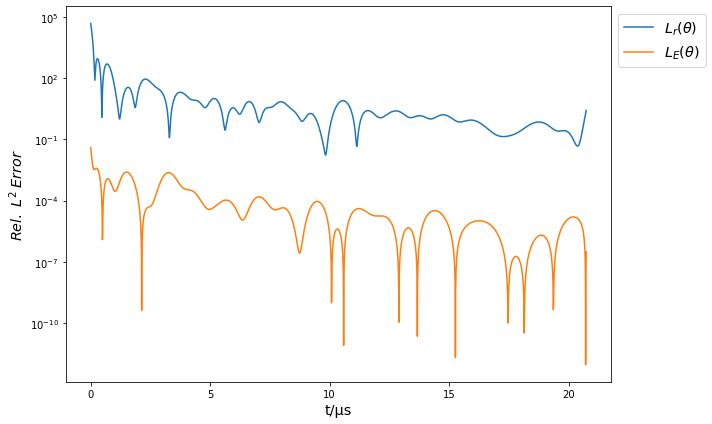

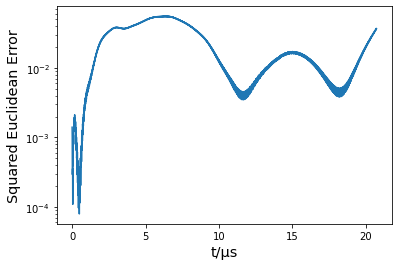

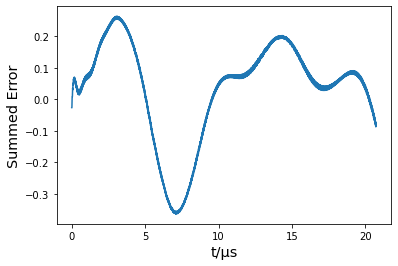

In [35]:
plt.figure(figsize=(10, 6))  # 设置图像大小为原始大小的1.3倍，10英寸6英寸
plt.plot(tl_array,lpde_tl_list,label=r'$L_{r}(\theta)$')
plt.plot(tl_array,lE_tl_list,label=r'$L_{E}(\theta)$')
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel(r'$Rel.\;L^2\;Error$', fontsize='x-large')
# plt.title('Loss of ODEs and loss of E from real data during motion process')
plt.legend(fontsize='x-large', loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()# 自动调整布局，确保图像完整显示
plt.show()

plt.plot(tl_array,loss_test_tl_list)
plt.yscale('log')  # 设置纵轴为对数刻度
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Squared Euclidean Error', fontsize='x-large')
# plt.title('Geometric differences of position from real data during motion process')

plt.show()#绘图

plt.plot(tl_array,lossmean_test_tl_list)
plt.xlabel('t/μs', fontsize='x-large')
plt.ylabel('Summed Error', fontsize='x-large')
# plt.title('Arithmetic differences of position from real data during motion process')

plt.show()#绘图

In [36]:
file_lists = [lpde_tl_list,  lE_tl_list,  loss_test_tl_list, lossmean_test_tl_list]
file_names = ['hh_lpde_tl_list.txt', 'hh_lE_tl_list.txt',  'hh_loss_test_tl_list.txt', 'hh_lossmean_test_tl_list.txt']

for file_list, old_name in zip(file_lists, file_names):
    new_name = new_prefix + old_name[2:]  # 保留原始文件名中的后缀部分
    with open(new_name, 'w') as f:
        for item in file_list:
            f.write("%s\n" % item)
